In [3]:
import datetime
import time
import urllib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime,timedelta
import calendar
from pytz import timezone
import googlemaps
%matplotlib inline
import pandas as pd
import sys
import tweepy

sys.path.append("/Users/mharias/documents/proyectos/mylibs") # directorio de acceso a librerías auxiliares


from pass_elgallo import token_elgalloaurora,apikey,apisecretkey,AccessToken,AccessTokenSecret,google_key
from pass_esios import token_walyt,apikey_walyt,apisecretkey_walyt,AccessToken_walyt,AccessTokenSecret_walyt

from astral import LocationInfo
from astral.sun import sun
import sched

# Test Mapa

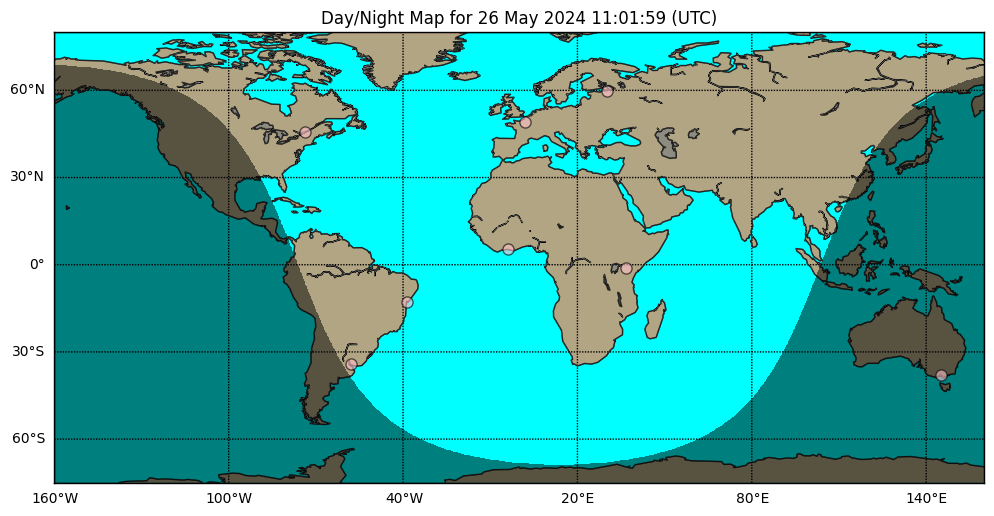

In [4]:
#map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,projection='mill',lon_0=0)
plt.figure(figsize=(12,6))
map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,lon_0=100)
#map = Basemap(llcrnrlon=-16, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
map.drawmapboundary(fill_color='aqua')
#map.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#map.fillcontinents(color='coral',lake_color='aqua')
map.fillcontinents(color='coral', alpha=0.7, lake_color='grey')
map.drawcoastlines(linewidth=0.1, color="white")

# shade the night areas, with alpha transparency so the
# map shows through. Use current time in UTC.
#date = datetime.now(timezone.utc)
#date = datetime.utcnow()
#date = datetime.now(timezone.utc)
date = datetime.now(timezone('utc'))
CS=map.nightshade(date)

data = pd.DataFrame({
'lat':[-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
'lon':[-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
'name':['Buenos Aires', 'Paris', 'melbourne', 'St Petersbourg', 'Abidjan', 'Montreal', 'Nairobi', 'Salvador']
})
# Add a marker per city of the data frame!
map.plot(data['lat'], data['lon'], linestyle='none', marker="o", markersize=8, 
         alpha=0.6, c="pink", markeredgecolor="black", markeredgewidth=1)

plt.title('Day/Night Map for %s (UTC)' % date.strftime("%d %b %Y %H:%M:%S"))
plt.show()

# Test Google

In [2]:

gmaps = googlemaps.Client(key=google_key)

# Geocoding an address
geocode_result = gmaps.geocode(['Almendralejo'])
#geocode_result = gmaps.timezone(location=(44,-1.0)) #latitude, longitude

In [3]:
geocode_result[0]['geometry']['location']

{'lat': 38.6914575, 'lng': -6.4058423}

In [69]:
gmaps.timezone(location=(38.6,-6.4))

{'dstOffset': 3600,
 'rawOffset': 3600,
 'status': 'OK',
 'timeZoneId': 'Europe/Madrid',
 'timeZoneName': 'Central European Summer Time'}

# Clase

In [2]:
class Gallo:
    consumer_key=''
    consumer_secret=''
    access_token_key=''
    access_token_secret=''
    google_key=''
    
    def __init__(self,consumer_key_,
               consumer_secret_,
               access_token_key_,
               access_token_secret_,
                google_key_):
        self.consumer_key=consumer_key_
        self.consumer_secret=consumer_secret_
        self.access_token_key=access_token_key_
        self.access_token_secret=access_token_secret_
        self.google_key=google_key_
        
    def load_cities_formatted(self,fichero_ciudades_formateados):
        self.path_fichero_ciudades_formateado=fichero_ciudades_formateados
        cities=pd.read_csv(fichero_ciudades_formateados,
                           names=['Pais','Ciudad','Continente','localizacion','Time_Zone','offset_UTC'])
        self.ciudades=cities
        self.ciudades['localizacion']=self.ciudades.apply(lambda x:ast.literal_eval(x['localizacion']),axis=1)
    
    def load_cities_raw(self,fichero_ciudades_raw):
        gmaps = googlemaps.Client(key=self.google_key)
        self.ciudades=pd.read_csv(fichero_ciudades_raw,names=['Pais','Ciudad','Continente'])
        self.ciudades['localizacion']=self.ciudades.apply(lambda x :self.lat_y_lon((x['Ciudad']+','+x['Pais']),gmaps),axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x :self.time_zone(x['localizacion'],gmaps),axis=1)
        self.ciudades['offset_UTC']=self.ciudades.apply(lambda x:x['Time_Zone'][0],axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x:x['Time_Zone'][1],axis=1)
        #self.ciudades['localizacion']=self.ciudades.apply(lambda x:ast.literal_eval(x['localizacion']),axis=1)
        
    def save_cities(self,path_fichero):
        self.ciudades.to_csv(path_fichero,header=False,index=False)

        
    def grados_a_radianes(self,grados_):
        return grados_/360*2*math.pi


    def radianes_a_grados(self,radianes_):
        return radianes_*360/2/math.pi


    def ecuacion_tiempo(self,dia_):
        valor=229.18*(-0.0334*math.sin(2*math.pi/365.24*dia_)+0.04184*math.sin(4*math.pi/365.24*dia_+3.5884))
        return valor


    def declinacion(self,n_):
        valor=-23.45*math.cos(self.grados_a_radianes(360/365*(n_+10)))
        return valor


    def angulo_solar(self,latitud_,declinacion_):
        a=math.sin(self.grados_a_radianes(-0.833))-math.sin(self.grados_a_radianes(latitud_))*math.sin(self.grados_a_radianes(declinacion_))
        b=math.cos(self.grados_a_radianes(declinacion_))*math.cos(self.grados_a_radianes(latitud_))
        cosenow=a/b
        return math.acos(cosenow)
    
    
    
    def lat_y_lon(self,x,gmaps):
        geocode_result=gmaps.geocode(x)
        return geocode_result[0]['geometry']['location']
    
    def time_zone(self,x,gmaps):
        timezone_result=gmaps.timezone(x)
        return timezone_result['rawOffset'],timezone_result['timeZoneName']
    
    
    def amanece_dia (self,latitud_,longitud_,dia_):
        
        timezone_utc=timezone('utc')
        dia_utc=timezone_utc.localize(dia_)
        orden_dia=int(dia_utc.strftime('%j'))
        declinacion_dia=self.declinacion(orden_dia)
        angulo=self.angulo_solar(latitud_,declinacion_dia)
        NHoras=self.radianes_a_grados(angulo)/7.5
        ajuste=self.ecuacion_tiempo(orden_dia)
        mediodia_solar=datetime.datetime(dia_.year,dia_.month,dia_.day,12,0,0)
        arco=datetime.timedelta(hours=NHoras/2)
        hora_amanecer_solar=mediodia_solar-arco
        hora_amanecer_utc=hora_amanecer_solar-datetime.timedelta(hours=longitud_/15)
        hora_amanecer_utc_ajustada=hora_amanecer_utc-datetime.timedelta(minutes=ajuste)
        hora_amanecer_utc_ajustada_localizada=timezone_utc.localize(hora_amanecer_utc_ajustada)
        hora_amanecer_utc_ajustada_localizada=hora_amanecer_utc_ajustada_localizada.replace(year=dia_.year,month=dia_.month,day=dia_.day)
        return hora_amanecer_utc_ajustada_localizada
        
    def anochece_dia (self,latitud_,longitud_,dia_):
        timezone_utc=timezone('utc')
        dia_utc=timezone_utc.localize(dia_)
        orden_dia=int(dia_.strftime('%j'))
        declinacion_dia=self.declinacion(orden_dia)
        angulo=self.angulo_solar(latitud_,declinacion_dia)
        NHoras=self.radianes_a_grados(angulo)/7.5
        ajuste=self.ecuacion_tiempo(orden_dia)
        mediodia_solar=datetime.datetime(dia_.year,dia_.month,dia_.day,12,0,0)
        arco=datetime.timedelta(hours=NHoras/2)
        hora_anochecer_solar=mediodia_solar+arco
        hora_anochecer_utc=hora_anochecer_solar-datetime.timedelta(hours=longitud_/15)
        hora_anochecer_utc_ajustada=hora_anochecer_utc-datetime.timedelta(minutes=ajuste)
        hora_anochecer_utc_ajustada_localizada=timezone_utc.localize(hora_anochecer_utc_ajustada)
        hora_anochecer_utc_ajustada_localizada=hora_anochecer_utc_ajustada_localizada.replace(year=dia_.year,month=dia_.month,day=dia_.day)
        return hora_anochecer_utc_ajustada_localizada
        
    #def annade_amanece_anochece(self):
    #    hora_comparativa='%H:%M:%S %m %d'
    #    ahora=datetime.datetime.utcnow()
    #    for i in self.ciudades.index:
    #    
    #    self.ciudades['amanece']=self.ciudades.apply(lambda x:self.amanece_dia(x['localizacion']['lat'],
    #                                                                      x['localizacion']['lng'],ahora).
    #                                                 strftime(hora_comparativa),axis=1)
    #    self.ciudades['anochece']=self.ciudades.apply(lambda x:self.anochece_dia(x['localizacion']['lat'],
    #                                                                      x['localizacion']['lng'],ahora).
    #                                                  strftime(hora_comparativa),axis=1)
     
    def annade_amanece_anochece(self):
        hora_comparativa='%H:%M:%S %m %d'
        un_dia=datetime.timedelta(days=1)
        ahora=datetime.datetime.utcnow()
        timezone_utc=timezone('utc')
        ahora_utc=timezone_utc.localize(ahora)
        serie_amanece=pd.Series()
        serie_anochece=pd.Series()
        for i in self.ciudades.index:
            hora=self.amanece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora)
            if hora<ahora_utc:
                hora=self.amanece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora+un_dia)
            serie_amanece.loc[i]=hora.strftime(hora_comparativa)
            self.ciudades['amanece']=serie_amanece
        for i in self.ciudades.index:
            hora=self.anochece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora)
            if hora<ahora_utc:
                hora=self.anochece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora+un_dia)
            serie_anochece.loc[i]=hora.strftime(hora_comparativa)
            self.ciudades['anochece']=serie_anochece
        return
    
    
    def mapa(self,path,lat,long,color):
        plt.figure(figsize=(12,6))
        map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,lon_0=100)
        map.drawcoastlines()
        map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
        map.drawmapboundary(fill_color='aqua')
        map.fillcontinents(color='coral', alpha=0.7, lake_color='grey')
        map.drawcoastlines(linewidth=0.1, color="white")
        date = datetime.datetime.utcnow()
        CS=map.nightshade(date)
        map.plot(long,lat, linestyle='none', marker="o", markersize=24,
                 alpha=0.6, c=color, markeredgecolor="black", markeredgewidth=1)
        plt.title('Day/Night Map for {} (UTC)'.format(date.strftime("%d %b %Y %H:%M:%S")))
        plt.savefig(path)
        plt.show()
        plt.close() #añadido para evitar muchas abiertas
        return path
    
    
    def send_tweet(self,ciudad,pais,continente,hora_local,hora_utc,nueva_hora,path,accion):
        CR='\n'
        hora='%H:%M:%S'
        textos={'amanece':('Good morning','sun rising'),'anochece':('Good evening','sunset')}
        api=twitter.Api(self.consumer_key,
               self.consumer_secret,
               self.access_token_key,
               self.access_token_secret,
               sleep_on_rate_limit=True)
        
        Text1=('{}, {} at {}, {} ({})'.format(textos[accion][0],textos[accion][1],'#'+ciudad.replace(' ',''),
                                                                  '#'+pais,'#'+continente))
        Text2=('{0:<10} {1:<15}'.format('UTC time',hora_utc.strftime(hora)))
        Text3=('{0:<10} {1:<15}'.format('Local time',hora_local.strftime(hora)))
        Text4=('{0:<10} {1} at {2:<15}'.format('Tomorrow',textos[accion][1],nueva_hora.strftime(hora)))
        Text5='#roostercrow'
        Text6='#elgallodelaaurora'
        texto=Text1+CR+Text2+CR+Text3+CR+Text4+CR+Text5+CR+Text6
        print (texto)
        estado = api.PostUpdate(texto,media=path)
        return                                                
    
    def run(self):
        hora_comparativa='%H:%M:%S %m %d'
        un_dia=datetime.timedelta(days=1)
        while True:
            ahora=datetime.datetime.utcnow()
            ahora_texto=ahora.strftime(hora_comparativa)
            #ahora_texto="02:08:36 02 17"
            lista_ciudades=self.ciudades[self.ciudades['amanece']==ahora_texto]
            
            if lista_ciudades.shape[0]!=0:
                #print (lista_ciudades.iloc[0])
                nueva_hora=self.amanece_dia(lista_ciudades.iloc[0]['localizacion']['lat'],
                                            lista_ciudades.iloc[0]['localizacion']['lng'],ahora+un_dia)
                self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais'])&
                                  (self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad']),
                                  ['amanece']]=nueva_hora.strftime(hora_comparativa)
                #print (self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais']) & 
                                    #(self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad'])])
                ahora_local=ahora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                nueva_hora_local=nueva_hora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                path=self.mapa('mapa.png',lista_ciudades.iloc[0]['localizacion']['lat'],
                          lista_ciudades.iloc[0]['localizacion']['lng'],'yellow')
                self.send_tweet(lista_ciudades.iloc[0]['Ciudad'],lista_ciudades.iloc[0]['Pais'],
                                lista_ciudades.iloc[0]['Continente'],ahora_local,ahora,nueva_hora_local,path,'amanece')
            
            lista_ciudades=self.ciudades[self.ciudades['anochece']==ahora_texto]
            if lista_ciudades.shape[0]!=0:
                #print (lista_ciudades.iloc[0])
                nueva_hora=self.anochece_dia(lista_ciudades.iloc[0]['localizacion']['lat'],
                                            lista_ciudades.iloc[0]['localizacion']['lng'],ahora+un_dia)
                self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais'])&(self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad']),['anochece']]=nueva_hora.strftime(hora_comparativa)
                #print (self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais']) & (self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad'])])
                ahora_local=ahora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                nueva_hora_local=nueva_hora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                path=self.mapa('mapa.png',lista_ciudades.iloc[0]['localizacion']['lat'],
                          lista_ciudades.iloc[0]['localizacion']['lng'],'blue')
                self.send_tweet(lista_ciudades.iloc[0]['Ciudad'],lista_ciudades.iloc[0]['Pais'],
                                lista_ciudades.iloc[0]['Continente'],ahora_local,ahora,nueva_hora_local,path,'anochece')

In [3]:
fichero='cities.csv'
fichero_format='cities_formatted.csv'
gallo=Gallo(apikey,apisecretkey,AccessToken,AccessTokenSecret,google_key)
gallo.load_cities_formatted(fichero_format)


In [ ]:
ahora_utc=datetime.datetime.utcnow()
ahora=datetime.datetime.now()
nueva_hora=ahora+un_dia
path='prueba.png'
accion='amanece'

In [4]:
gallo.annade_amanece_anochece()

In [ ]:
gallo.send_tweet('Madrid','Spain','Europa',hora,ahora_utc,nueva_hora,path,accion)

/Users/waly/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


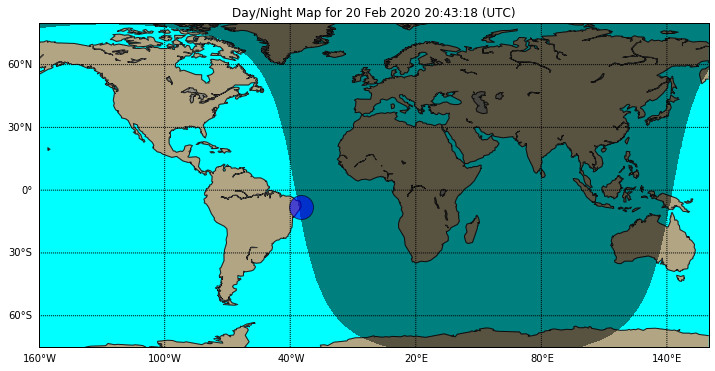

Good evening, sunset at #Recife, #Brazil (#America)
UTC time   20:43:18       
Local time 17:43:18       
Tomorrow   sunset at 17:42:58       
#roostercrow
#elgallodelaaurora


In [ ]:
gallo.run()

In [ ]:
hora=datetime.datetime.strptime(gallo.ciudades.loc[0]['amanece'],'%H:%M:%S %m %d').replace(year=2020)

In [ ]:
horas=gallo.ciudades['anochece'].apply(lambda x:datetime.datetime.strptime(x,'%H:%M:%S %m %d').replace(year=2020))

In [ ]:
ahora=datetime.datetime.utcnow()

In [ ]:
(horas>ahora).sum()

# Taller

In [57]:
gmaps.geocode(['Almendralejo'])[0]['geometry']['location']

{'lat': 38.6914575, 'lng': -6.4058423}

In [58]:
city = LocationInfo("Almendralejo", "España", "Euarope/Almendralejo", gmaps.geocode(['Almendralejo'])[0]['geometry']['location']['lat'], gmaps.geocode(['Almendralejo'])[0]['geometry']['location']['lng'])

In [65]:
s = sun(city.observer, date=datetime(2024, 5, 25))

In [66]:
print((
    f'Dawn:    {s["dawn"]}\n'
    f'Sunrise: {s["sunrise"]}\n'
    f'Noon:    {s["noon"]}\n'
    f'Sunset:  {s["sunset"]}\n'
    f'Dusk:    {s["dusk"]}\n'))

Dawn:    2024-05-25 04:34:54.514951+00:00
Sunrise: 2024-05-25 05:06:15.787193+00:00
Noon:    2024-05-25 12:22:34+00:00
Sunset:  2024-05-25 19:39:25.115729+00:00
Dusk:    2024-05-25 20:10:51.271669+00:00



In [64]:
datetime(year=2024,month=5,day=25)

datetime.datetime(2024, 5, 25, 0, 0)

In [ ]:
        
    def load_cities_formatted(self,fichero_ciudades_formateados):
        self.path_fichero_ciudades_formateado=fichero_ciudades_formateados
        cities=pd.read_csv(fichero_ciudades_formateados,
                           names=['Pais','Ciudad','Continente','localizacion','Time_Zone','offset_UTC'])
        self.ciudades=cities
        self.ciudades['localizacion']=self.ciudades.apply(lambda x:ast.literal_eval(x['localizacion']),axis=1)
    

In [ ]:
    def load_cities_raw(self,fichero_ciudades_raw):
        gmaps = googlemaps.Client(key=self.google_key)
        self.ciudades=pd.read_csv(fichero_ciudades_raw,names=['Pais','Ciudad','Continente'])
        self.ciudades['localizacion']=self.ciudades.apply(lambda x :self.lat_y_lon((x['Ciudad']+','+x['Pais']),gmaps),axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x :self.time_zone(x['localizacion'],gmaps),axis=1)
        self.ciudades['offset_UTC']=self.ciudades.apply(lambda x:x['Time_Zone'][0],axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x:x['Time_Zone'][1],axis=1)
        #self.ciudades['localizacion']=self.ciudades.apply(lambda x:ast.literal_eval(x['localizacion']),axis=1)

In [ ]:
        
    def save_cities(self,path_fichero):
        self.ciudades.to_csv(path_fichero,header=False,index=False)

In [ ]:
        
def grados_a_radianes(self,grados_):
    return grados_/360*2*math.pi

In [ ]:
def radianes_a_grados(self,radianes_):
    return radianes_*360/2/math.pi

In [ ]:
def ecuacion_tiempo(self,dia_):
    valor=229.18*(-0.0334*math.sin(2*math.pi/365.24*dia_)+0.04184*math.sin(4*math.pi/365.24*dia_+3.5884))
    return valor

In [ ]:
def declinacion(self,n_):
    valor=-23.45*math.cos(self.grados_a_radianes(360/365*(n_+10)))
    return valor

In [ ]:
def angulo_solar(self,latitud_,declinacion_):
    a=math.sin(self.grados_a_radianes(-0.833))-math.sin(self.grados_a_radianes(latitud_))*math.sin(self.grados_a_radianes(declinacion_))
    b=math.cos(self.grados_a_radianes(declinacion_))*math.cos(self.grados_a_radianes(latitud_))
    cosenow=a/b
    return math.acos(cosenow)


    

In [ ]:
def lat_y_lon(self,x,gmaps):
    geocode_result=gmaps.geocode(x)
    return geocode_result[0]['geometry']['location']
    

In [ ]:
def time_zone(self,x,gmaps):
    timezone_result=gmaps.timezone(x)
    return timezone_result['rawOffset'],timezone_result['timeZoneName']


In [5]:
    
def amanece_dia (latitud_,longitud_,dia_):
    
    timezone_utc=timezone('utc')
    dia_utc=timezone_utc.localize(dia_)
    orden_dia=int(dia_utc.strftime('%j'))
    declinacion_dia=self.declinacion(orden_dia)
    angulo=self.angulo_solar(latitud_,declinacion_dia)
    NHoras=self.radianes_a_grados(angulo)/7.5
    ajuste=self.ecuacion_tiempo(orden_dia)
    mediodia_solar=datetime.datetime(dia_.year,dia_.month,dia_.day,12,0,0)
    arco=datetime.timedelta(hours=NHoras/2)
    hora_amanecer_solar=mediodia_solar-arco
    hora_amanecer_utc=hora_amanecer_solar-datetime.timedelta(hours=longitud_/15)
    hora_amanecer_utc_ajustada=hora_amanecer_utc-datetime.timedelta(minutes=ajuste)
    hora_amanecer_utc_ajustada_localizada=timezone_utc.localize(hora_amanecer_utc_ajustada)
    hora_amanecer_utc_ajustada_localizada=hora_amanecer_utc_ajustada_localizada.replace(year=dia_.year,month=dia_.month,day=dia_.day)
    return hora_amanecer_utc_ajustada_localizada
       

In [9]:
timezone('utc').localize(datetime.now()).strftime('%j')

'146'

In [12]:
gmaps.geocode(['Almendralejo'])

[{'address_components': [{'long_name': 'Almendralejo',
    'short_name': 'Almendralejo',
    'types': ['locality', 'political']},
   {'long_name': 'Badajoz',
    'short_name': 'BA',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Extremadura',
    'short_name': 'EX',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'Spain',
    'short_name': 'ES',
    'types': ['country', 'political']},
   {'long_name': '06200', 'short_name': '06200', 'types': ['postal_code']}],
  'formatted_address': '06200 Almendralejo, Badajoz, Spain',
  'geometry': {'bounds': {'northeast': {'lat': 38.7012781, 'lng': -6.3829794},
    'southwest': {'lat': 38.66559609999999, 'lng': -6.4377341}},
   'location': {'lat': 38.6914575, 'lng': -6.4058423},
   'location_type': 'APPROXIMATE',
   'viewport': {'northeast': {'lat': 38.7012781, 'lng': -6.3829794},
    'southwest': {'lat': 38.66559609999999, 'lng': -6.4377341}}},
  'place_id': 'ChIJ5ar6_4CnFg0RdN5FkuEVvMs',


In [22]:
calendar

NameError: name 'calendar' is not defined

In [20]:
time.time()

1716628877.4931579

In [16]:
time.localtime(time.time())

time.struct_time(tm_year=2024, tm_mon=5, tm_mday=25, tm_hour=11, tm_min=17, tm_sec=6, tm_wday=5, tm_yday=146, tm_isdst=1)

In [17]:
time.gmtime(time.time())

time.struct_time(tm_year=2024, tm_mon=5, tm_mday=25, tm_hour=9, tm_min=17, tm_sec=29, tm_wday=5, tm_yday=146, tm_isdst=0)

In [21]:
datetime.strptime('Jul 9, 2009 @ 20:02:58 UTC',"%b %d, %Y @ %H:%M:%S %Z").strftime('%s')

'1247162578'

ModuleNotFoundError: No module named 'tzwhere'

In [3]:
datetime.now(timezone('utc'))

datetime.datetime(2024, 5, 25, 9, 5, 22, 333533, tzinfo=<UTC>)

In [ ]:
amanece_dia(40.41,-3.7,)

In [ ]:
 
def anochece_dia (self,latitud_,longitud_,dia_):
    timezone_utc=timezone('utc')
    dia_utc=timezone_utc.localize(dia_)
    orden_dia=int(dia_.strftime('%j'))
    declinacion_dia=self.declinacion(orden_dia)
    angulo=self.angulo_solar(latitud_,declinacion_dia)
    NHoras=self.radianes_a_grados(angulo)/7.5
    ajuste=self.ecuacion_tiempo(orden_dia)
    mediodia_solar=datetime.datetime(dia_.year,dia_.month,dia_.day,12,0,0)
    arco=datetime.timedelta(hours=NHoras/2)
    hora_anochecer_solar=mediodia_solar+arco
    hora_anochecer_utc=hora_anochecer_solar-datetime.timedelta(hours=longitud_/15)
    hora_anochecer_utc_ajustada=hora_anochecer_utc-datetime.timedelta(minutes=ajuste)
    hora_anochecer_utc_ajustada_localizada=timezone_utc.localize(hora_anochecer_utc_ajustada)
    hora_anochecer_utc_ajustada_localizada=hora_anochecer_utc_ajustada_localizada.replace(year=dia_.year,month=dia_.month,day=dia_.day)
    return hora_anochecer_utc_ajustada_localizada
        
    #def annade_amanece_anochece(self):
    #    hora_comparativa='%H:%M:%S %m %d'
    #    ahora=datetime.datetime.utcnow()
    #    for i in self.ciudades.index:
    #    
    #    self.ciudades['amanece']=self.ciudades.apply(lambda x:self.amanece_dia(x['localizacion']['lat'],
    #                                                                      x['localizacion']['lng'],ahora).
    #                                                 strftime(hora_comparativa),axis=1)
    #    self.ciudades['anochece']=self.ciudades.apply(lambda x:self.anochece_dia(x['localizacion']['lat'],
    #                                                                      x['localizacion']['lng'],ahora).
    #                                                  strftime(hora_comparativa),axis=1)
     

In [ ]:
def annade_amanece_anochece(self):
    hora_comparativa='%H:%M:%S %m %d'
    un_dia=datetime.timedelta(days=1)
    ahora=datetime.datetime.utcnow()
    timezone_utc=timezone('utc')
    ahora_utc=timezone_utc.localize(ahora)
    serie_amanece=pd.Series()
    serie_anochece=pd.Series()
    for i in self.ciudades.index:
        hora=self.amanece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                              self.ciudades.loc[i]['localizacion']['lng'],ahora)
        if hora<ahora_utc:
            hora=self.amanece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                              self.ciudades.loc[i]['localizacion']['lng'],ahora+un_dia)
        serie_amanece.loc[i]=hora.strftime(hora_comparativa)
        self.ciudades['amanece']=serie_amanece
    for i in self.ciudades.index:
        hora=self.anochece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                              self.ciudades.loc[i]['localizacion']['lng'],ahora)
        if hora<ahora_utc:
            hora=self.anochece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                              self.ciudades.loc[i]['localizacion']['lng'],ahora+un_dia)
        serie_anochece.loc[i]=hora.strftime(hora_comparativa)
        self.ciudades['anochece']=serie_anochece
    return
    
    

In [19]:
def mapa(self,path,lat,long,color):
    plt.figure(figsize=(12,6))
    map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,lon_0=100)
    map.drawcoastlines()
    map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
    map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
    map.drawmapboundary(fill_color='aqua')
    map.fillcontinents(color='coral', alpha=0.7, lake_color='grey')
    map.drawcoastlines(linewidth=0.1, color="white")
    date = datetime.datetime.utcnow()
    CS=map.nightshade(date)
    map.plot(long,lat, linestyle='none', marker="o", markersize=24,
             alpha=0.6, c=color, markeredgecolor="black", markeredgewidth=1)
    plt.title('Day/Night Map for {} (UTC)'.format(date.strftime("%d %b %Y %H:%M:%S")))
    plt.savefig(path)
    plt.show()
    plt.close() #añadido para evitar muchas abiertas
    return path

    

In [ ]:
hora_comparativa='%H:%M:%S %m %d'
un_dia=datetime.timedelta(days=1)
while True:
    ahora=datetime.datetime.utcnow()
    ahora_texto=ahora.strftime(hora_comparativa)
    #ahora_texto="02:08:36 02 17"
    lista_ciudades=self.ciudades[self.ciudades['amanece']==ahora_texto]
    
    if lista_ciudades.shape[0]!=0:
        #print (lista_ciudades.iloc[0])
        nueva_hora=self.amanece_dia(lista_ciudades.iloc[0]['localizacion']['lat'],
                                    lista_ciudades.iloc[0]['localizacion']['lng'],ahora+un_dia)
        self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais'])&
                          (self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad']),
                          ['amanece']]=nueva_hora.strftime(hora_comparativa)
        #print (self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais']) & 
                            #(self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad'])])
        ahora_local=ahora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
        nueva_hora_local=nueva_hora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
        path=self.mapa('mapa.png',lista_ciudades.iloc[0]['localizacion']['lat'],
                  lista_ciudades.iloc[0]['localizacion']['lng'],'yellow')
        self.send_tweet(lista_ciudades.iloc[0]['Ciudad'],lista_ciudades.iloc[0]['Pais'],
                        lista_ciudades.iloc[0]['Continente'],ahora_local,ahora,nueva_hora_local,path,'amanece')
    
    lista_ciudades=self.ciudades[self.ciudades['anochece']==ahora_texto]
    if lista_ciudades.shape[0]!=0:
        #print (lista_ciudades.iloc[0])
        nueva_hora=self.anochece_dia(lista_ciudades.iloc[0]['localizacion']['lat'],
                                    lista_ciudades.iloc[0]['localizacion']['lng'],ahora+un_dia)
        self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais'])&(self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad']),['anochece']]=nueva_hora.strftime(hora_comparativa)
        #print (self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais']) & (self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad'])])
        ahora_local=ahora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
        nueva_hora_local=nueva_hora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
        path=self.mapa('mapa.png',lista_ciudades.iloc[0]['localizacion']['lat'],
                  lista_ciudades.iloc[0]['localizacion']['lng'],'blue')
        self.send_tweet(lista_ciudades.iloc[0]['Ciudad'],lista_ciudades.iloc[0]['Pais'],
                        lista_ciudades.iloc[0]['Continente'],ahora_local,ahora,nueva_hora_local,path,'anochece')

In [23]:
import calendar

In [47]:
time.time()

1716629671.001274

In [40]:
time.gmtime(time.time())

time.struct_time(tm_year=2024, tm_mon=5, tm_mday=25, tm_hour=9, tm_min=30, tm_sec=23, tm_wday=5, tm_yday=146, tm_isdst=0)

In [35]:
calendar.timegm(time.gmtime(time.time()))

1716629366

In [41]:
calendar.timegm()

TypeError: timegm() missing 1 required positional argument: 'tuple'

In [50]:
calendar.timegm(datetime.now(timezone('utc')).timetuple())

1716632320

In [49]:
pd.read_csv('cities_long_formatted.csv')

Ciudad         Pais Continente   longitud    latitud  \
0                 Kabul  Afghanistan       Asia  69.207486  34.555349   
1                Tirana      Albania     Europe  19.818698  41.327546   
2               Algiers      Algeria     Africa   3.058756  36.753768   
3      Andorra la Vella      Andorra     Europe   1.521835  42.506317   
4                Luanda       Angola     Africa  13.230176  -8.814656   
..                  ...          ...        ...        ...        ...   
209             Seville        Spain     Europe  -5.984459  37.389092   
210          Pontevedra        Spain     Europe  -8.644620  42.429885   
211  Pozuelo de Alarcon        Spain     Europe  -3.807415  40.447527   
212           Las Rozas        Spain     Europe  -3.875792  40.493533   
213            Tel Aviv       Israel       Asia  34.781768  32.085300   

     dstOffset  rawOffset      timeZoneId                    timeZoneName  
0            0      16200      Asia/Kabul                Afghanistan Time  
1         3600       3600   Europe/Tirane    Central European Summer Time  
2            0       3600  Africa/Algiers  Central European Standard Time  
3         3600       3600  Europe/Andorra    Central European Summer Time  
4            0       3600   Africa/Luanda       West Africa Standard Time  
..         ...        ...             ...                             ...  
209       3600       3600   Europe/Madrid    Central European Summer Time  
210       3600       3600   Europe/Madrid    Central European Summer Time  
211       3600       3600   Europe/Madrid    Central European Summer Time  
212       3600       3600   Europe/Madrid    Central European Summer Time  
213       3600       7200  Asia/Jerusalem            Israel Daylight Time  

[214 rows x 9 columns]

In [72]:
def load_cities_raw(self,fichero_ciudades_raw):
        gmaps = googlemaps.Client(key=self.google_key)
        self.ciudades=pd.read_csv(fichero_ciudades_raw,names=['Pais','Ciudad','Continente'])
        self.ciudades['localizacion']=self.ciudades.apply(lambda x :self.lat_y_lon((x['Ciudad']+','+x['Pais']),gmaps),axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x :self.time_zone(x['localizacion'],gmaps),axis=1)
        self.ciudades['offset_UTC']=self.ciudades.apply(lambda x:x['Time_Zone'][0],axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x:x['Time_Zone'][1],axis=1)
        #self.ciudades['localizacion']=self.ciudades.apply(lambda x:ast.literal_eval(x['localizacion']),axis=1)
        

12840

In [99]:
gmaps.timezone(location={'lat': 36.753768, 'lng': 3.0587561})

{'dstOffset': 0,
 'rawOffset': 3600,
 'status': 'OK',
 'timeZoneId': 'Africa/Algiers',
 'timeZoneName': 'Central European Standard Time'}

In [85]:
gmaps.geocode('Algiers,Algeria')[0]['geometry']['location']

{'lat': 36.753768, 'lng': 3.0587561}

In [93]:
datos = (pd.read_csv('cities_resumido.csv',names=['Pais','Ciudad','Continente']).loc[:4,:]
 .assign(localizacion = lambda x : x['Ciudad']+','+x['Pais'])
 .assign(localizacion = lambda df_ : df_.localizacion.map(lambda x: gmaps.geocode(x)[0]['geometry']['location']))
 #.assign(longitud= lambda df_ : dict(df_.localizacion.map(df_))['lng'])
 #.assign(latitud= lambda df_ : df_.localizacion.map(x['lat']) )
)

In [102]:
datos = (datos
 .assign(longitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lng']))
 .assign(latitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lat']))
 .assign(timezone = lambda df_ : df_.localizacion.map(lambda x: gmaps.timezone(x)))
)

In [104]:
datos.timezone

0    {'dstOffset': 0, 'rawOffset': 3600, 'status': ...
1    {'dstOffset': 0, 'rawOffset': 3600, 'status': ...
2    {'dstOffset': 0, 'rawOffset': -10800, 'status'...
3    {'dstOffset': 0, 'rawOffset': 36000, 'status':...
4    {'dstOffset': 3600, 'rawOffset': 3600, 'status...
Name: timezone, dtype: object

In [4]:
ciudades = (pd.read_csv('cities_resumido.csv',names=['Pais','Ciudad','Continente']).loc[:,:]
.assign(localizacion = lambda x : x['Ciudad']+','+x['Pais'])
.assign(localizacion = lambda df_ : df_.localizacion.map(lambda x: gmaps.geocode(x)[0]['geometry']['location']))
.assign(longitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lng']))
.assign(latitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lat']))
.assign(timezone = lambda df_ : df_.localizacion.map(lambda x: gmaps.timezone(x)))
.assign(dstOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['dstOffset']))
.assign(rawOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['rawOffset']))
.assign(timeZoneId = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneId']))
.assign(timeZoneName = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneName']))
.loc[:,['Ciudad','Pais','Continente','longitud','latitud','dstOffset','rawOffset','timeZoneId','timeZoneName']]
.set_index('Ciudad')
)

In [ ]:
ciudades = (pd.read_csv('cities.csv',names=['Pais','Ciudad','Continente']).loc[:,:]
.assign(localizacion = lambda x : x['Ciudad']+','+x['Pais'])
.assign(localizacion = lambda df_ : df_.localizacion.map(lambda x: gmaps.geocode(x)[0]['geometry']['location']))
.assign(longitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lng']))
.assign(latitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lat']))
.assign(timezone = lambda df_ : df_.localizacion.map(lambda x: gmaps.timezone(x)))
.assign(dstOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['dstOffset']))
.assign(rawOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['rawOffset']))
.assign(timeZoneId = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneId']))
.assign(timeZoneName = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneName']))
.loc[:,['Ciudad','Pais','Continente','longitud','latitud','dstOffset','rawOffset','timeZoneId','timeZoneName']]
.set_index('Ciudad')
)

In [29]:
def loc(x):
    print (f"Geocode {x}")
    return gmaps.geocode(x)[0]['geometry']['location']

def tz(x):
    print (f"Tzone {x}")
    return gmaps.timezone(x)

In [30]:
ciudades_long = (pd.read_csv('cities.csv',names=['Pais','Ciudad','Continente']).loc[:,:]
.assign(localizacion = lambda x : x['Ciudad']+','+x['Pais'])
.assign(localizacion = lambda df_ : df_.localizacion.map(loc))
.assign(longitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lng']))
.assign(latitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lat']))
.assign(timezone = lambda df_ : df_.localizacion.map(tz))
.assign(dstOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['dstOffset']))
.assign(rawOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['rawOffset']))
.assign(timeZoneId = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneId']))
.assign(timeZoneName = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneName']))
.loc[:,['Ciudad','Pais','Continente','longitud','latitud','dstOffset','rawOffset','timeZoneId','timeZoneName']]
.set_index('Ciudad')
)

Geocode Kabul,Afghanistan
Geocode Tirana,Albania
Geocode Algiers,Algeria
Geocode Andorra la Vella,Andorra
Geocode Luanda,Angola
Geocode St. John's,Antigua and Barbuda
Geocode Buenos Aires,Argentina
Geocode Yerevan,Armenia
Geocode Canberra,Australia
Geocode Vienna,Austria
Geocode Baku,Azerbaijan
Geocode Nassau,Bahamas
Geocode Manama,Bahrain
Geocode Dhaka,Bangladesh
Geocode Bridgetown,Barbados
Geocode Minsk,Belarus
Geocode Brussels,Belgium
Geocode Belmopan,Belize
Geocode Porto Novo,Benin
Geocode Thimphu,Bhutan
Geocode Sucre,Bolivia
Geocode Sarajevo,Bosnia and Herzegovina
Geocode Gaborone,Botswana
Geocode Brasilia,Brazil
Geocode Bandar Seri Begawan,Brunei
Geocode Sofia,Bulgaria
Geocode Ouagadougou,Burkina Faso
Geocode Bujumbura,Burundi
Geocode Phnom Penh,Cambodia
Geocode Yaoundé,Cameroon
Geocode Ottawa,Canada
Geocode Praia,Cape Verde
Geocode Bangui,Central African Republic
Geocode N'Djamena,Chad
Geocode Santiago,Chile
Geocode Beijing,China
Geocode Bogota,Colombia
Geocode Moroni,Comoros
Ge

In [34]:
ciudades_long.reset_index().to_csv('cities_long_formatted.csv',index=False)

In [35]:
ciudades.reset_index().to_csv('cities_formatted.csv',index=False)

In [36]:
ciudades = ciudades_long

In [41]:
def accion(ciudad='Madrid',que='amanece',hora=''):
    city = LocationInfo(ciudad, ciudades.loc[ciudad,'Pais'], ciudades.loc[ciudad,'timeZoneId'], ciudades.loc[ciudad,'latitud'], ciudades.loc[ciudad,'longitud'])
    mañana = datetime.now(timezone('UTC'))+timedelta(days=1)
    sol = sun(city.observer, date=mañana)
    #map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,projection='mill',lon_0=0)
    plt.figure(figsize=(12,6))
    map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,lon_0=100)
    #map = Basemap(llcrnrlon=-16, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80)
    # plot coastlines, draw label meridians and parallels.
    map.drawcoastlines()
    map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
    map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
    # fill continents 'coral' (with zorder=0), color wet areas 'aqua'
    map.drawmapboundary(fill_color='aqua')
    #map.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
    #map.fillcontinents(color='coral',lake_color='aqua')
    map.fillcontinents(color='coral', alpha=0.7, lake_color='grey')
    map.drawcoastlines(linewidth=0.1, color="white")
    
    # shade the night areas, with alpha transparency so the
    # map shows through. Use current time in UTC.
    #date = datetime.now(timezone.utc)
    #date = datetime.utcnow()
    #date = datetime.now(timezone.utc)
    date = datetime.now(timezone('utc'))
    CS=map.nightshade(date)
    
    # Add a marker per city of the data frame!
    map.plot(ciudades.loc[ciudad,'longitud'], ciudades.loc[ciudad,'latitud'], linestyle='none', marker='o', markersize=8, 
             alpha=0.6, c="pink", markeredgecolor="black", markeredgewidth=1)
    
    plt.title('Day/Night Map for %s (UTC)' % date.strftime("%d %b %Y %H:%M:%S"))
    plt.show()
    if que=='amanece':
        print (f"Sunrising at {ciudad}. It´s {hora.astimezone(timezone(ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')} LocalTime")
        nueva_hora = sol['sunrise']
        s.enterabs(calendar.timegm(sol['sunrise'].timetuple()),1,accion,kwargs={'ciudad':ciudad,'que':que,'hora':sol['sunrise']})
        print(f"Añadida nueva hora amanecer: {sol['sunrise'].astimezone(timezone(ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')}")
    if que=='anochece':
        print (f"Sunseting at {ciudad}. It´s {hora.astimezone(timezone(ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')} LocalTime")
        nueva_hora = sol['sunset']
        s.enterabs(calendar.timegm(sol['sunset'].timetuple()),1,accion,kwargs={'ciudad':ciudad,'que':que,'hora':sol['sunset']})
        print(f"Añadida nueva hora anochecer:{sol['sunset'].astimezone(timezone(ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')}")
    
    return

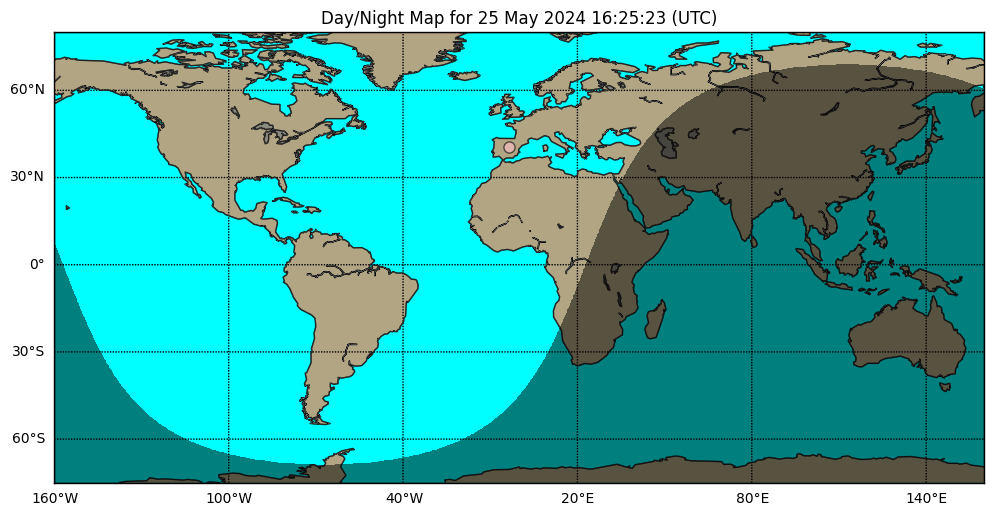

Sunrising at Madrid. It´s 18:25 LocalTime
Añadida nueva hora amanecer: 06:49


In [14]:
accion(ciudad='Madrid',que='amanece',hora=datetime.now())

In [44]:
for i in ciudades.index:
    city = LocationInfo(i, ciudades.loc[i,'Pais'], ciudades.loc[i,'timeZoneId'], ciudades.loc[i,'latitud'], ciudades.loc[i,'longitud'])
    hoy = datetime.today() #.astimezone(timezone(ciudades.loc[i,'timeZoneId']))
    try:
        sol = sun(city.observer, date=hoy)
        print (f"{city.name}: amanece a las {sol['sunrise'].strftime('%H:%M')}/{sol['sunrise'].astimezone(timezone(ciudades.loc[i,'timeZoneId'])).strftime('%H:%M')}@{calendar.timegm(sol['sunrise'].timetuple())}, anochece a las {sol['sunset'].strftime('%H:%M')}@{calendar.timegm(sol['sunset'].timetuple())}")
        if sol['sunrise']>datetime.now(timezone('UTC')):
            s.enterabs(calendar.timegm(sol['sunrise'].timetuple()),1,accion,kwargs={'ciudad':city.name,'que':'amanece','hora':sol['sunrise']})
        if sol['sunset']>datetime.now(timezone('UTC')):
            s.enterabs(calendar.timegm(sol['sunset'].timetuple()),1,accion,kwargs={'ciudad':city.name,'que':'anochece','hora':sol['sunset']})
    except:
        continue        

Kabul: amanece a las 00:14/04:44@1716596071, anochece a las 14:26@1716647167
Tirana: amanece a las 03:13/05:13@1716606832, anochece a las 18:02@1716660123
Algiers: amanece a las 04:33/05:33@1716611613, anochece a las 18:56@1716663381
Andorra la Vella: amanece a las 04:23/06:23@1716611005, anochece a las 19:18@1716664735
Luanda: amanece a las 05:14/06:14@1716614058, anochece a las 16:53@1716656027
St. John's: amanece a las 09:33/05:33@1716629612, anochece a las 22:35@1716676525
Buenos Aires: amanece a las 10:47/07:47@1716634078, anochece a las 20:52@1716670373
Yerevan: amanece a las 01:38/05:38@1716601108, anochece a las 16:19@1716653990
Canberra: amanece a las 20:59/06:59@1716670786, anochece a las 07:01@1716620492
Vienna: amanece a las 03:03/05:03@1716606237, anochece a las 18:39@1716662383
Baku: amanece a las 01:16/05:16@1716599786, anochece a las 15:59@1716652743
Nassau: amanece a las 10:21/06:21@1716632466, anochece a las 23:51@1716681118
Manama: amanece a las 01:47/04:47@171660162

In [42]:
s = sched.scheduler(time.time,time.sleep)

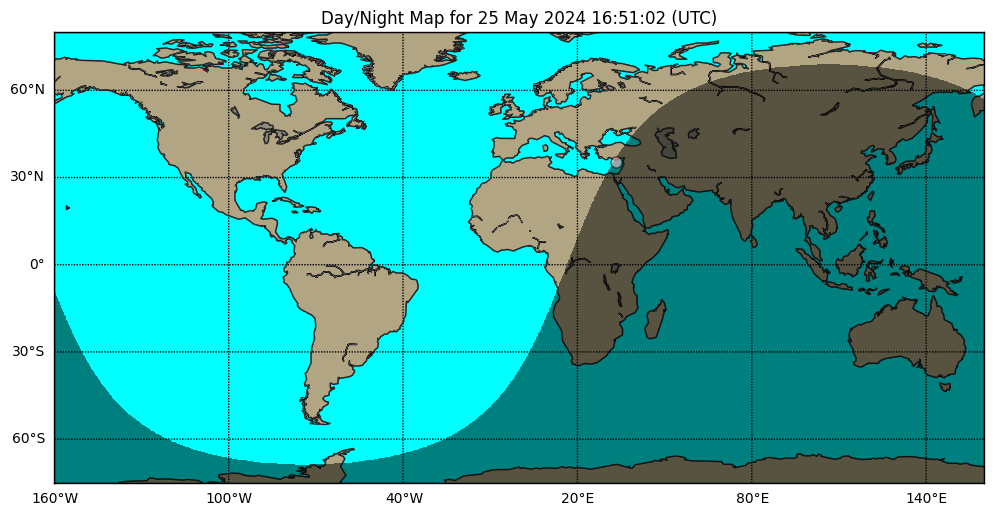

Sunseting at Nicosia. It´s 19:51 LocalTime
Añadida nueva hora anochecer:19:51


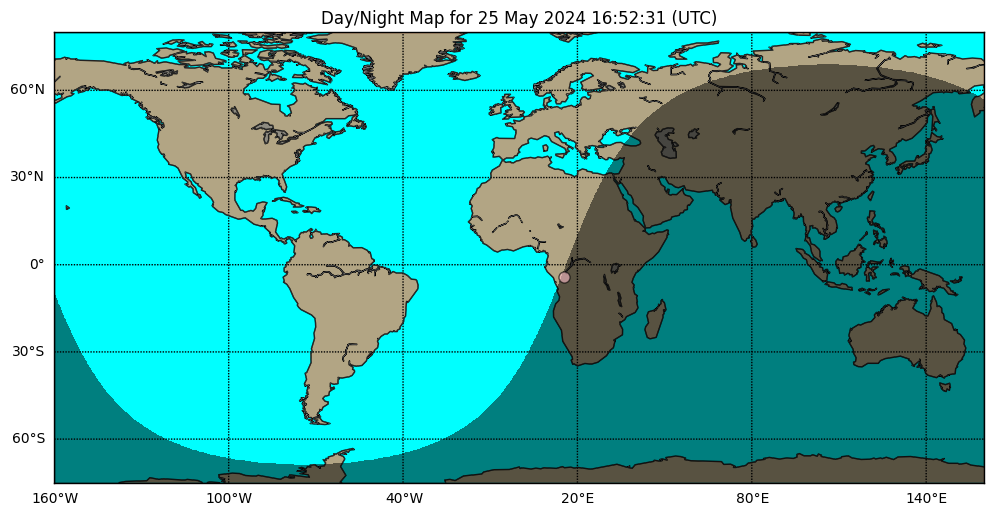

Sunseting at Kinshasa. It´s 17:52 LocalTime
Añadida nueva hora anochecer:17:52


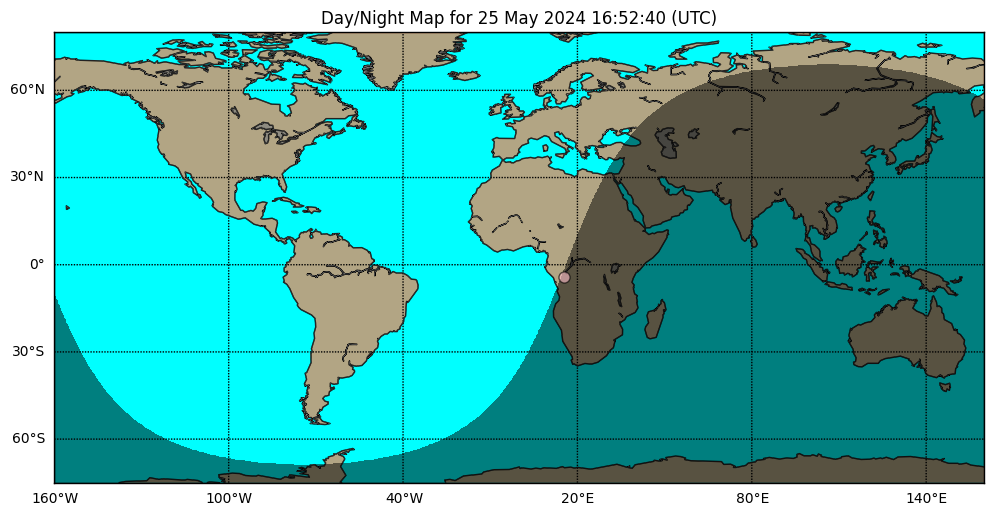

Sunseting at Brazzaville. It´s 17:52 LocalTime
Añadida nueva hora anochecer:17:52


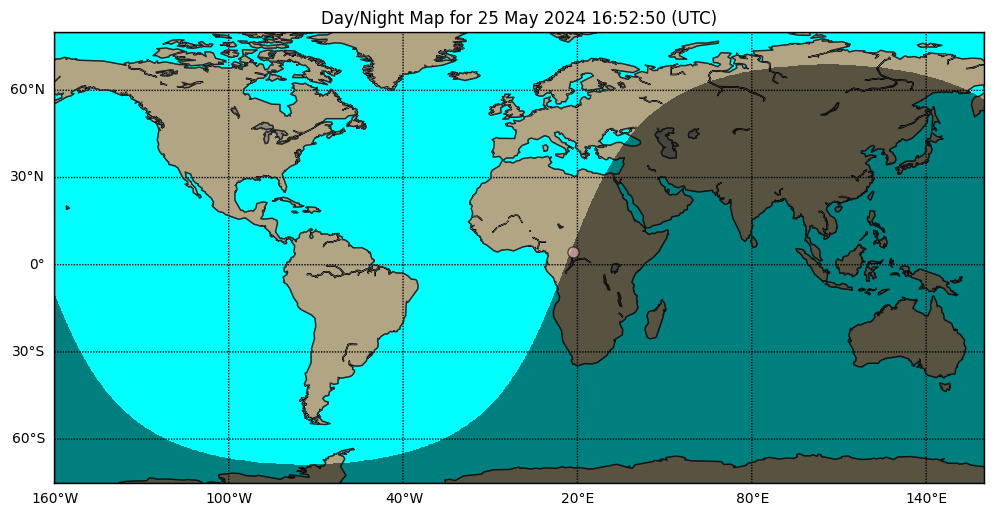

Sunseting at Bangui. It´s 17:52 LocalTime
Añadida nueva hora anochecer:17:53


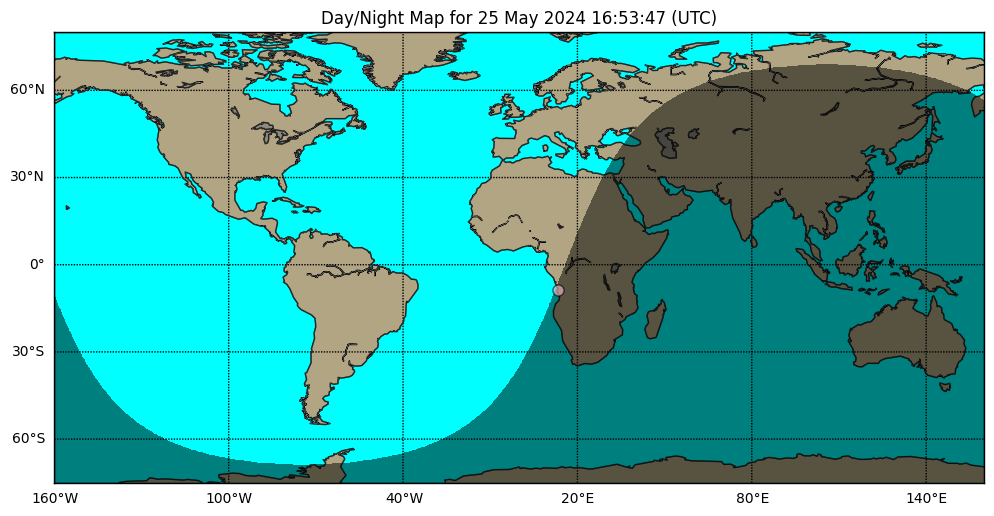

Sunseting at Luanda. It´s 17:53 LocalTime
Añadida nueva hora anochecer:17:53


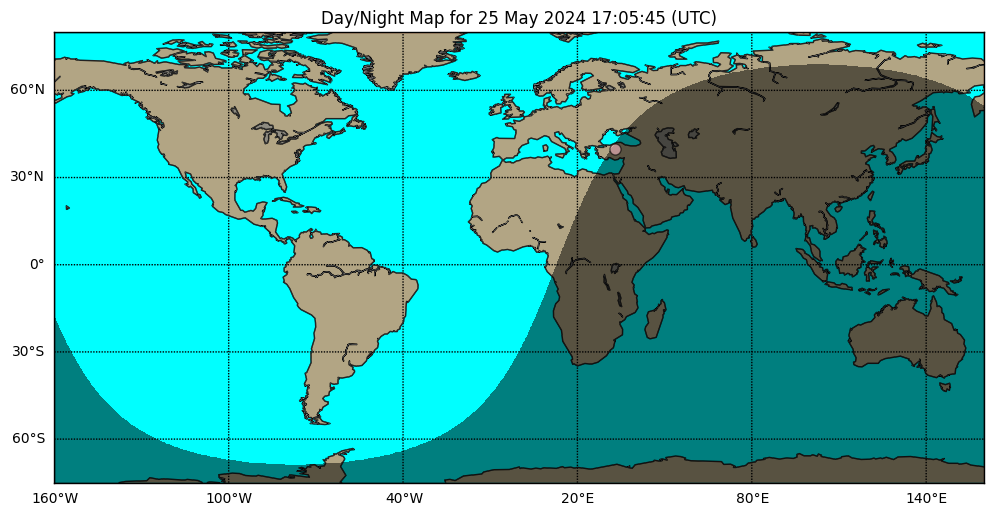

Sunseting at Ankara. It´s 20:05 LocalTime
Añadida nueva hora anochecer:20:06


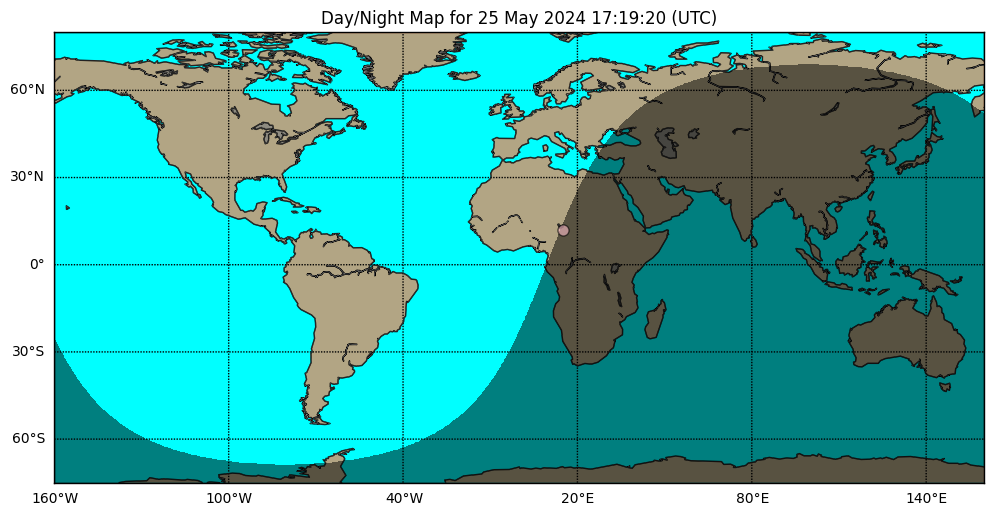

Sunseting at N'Djamena. It´s 18:19 LocalTime
Añadida nueva hora anochecer:18:19


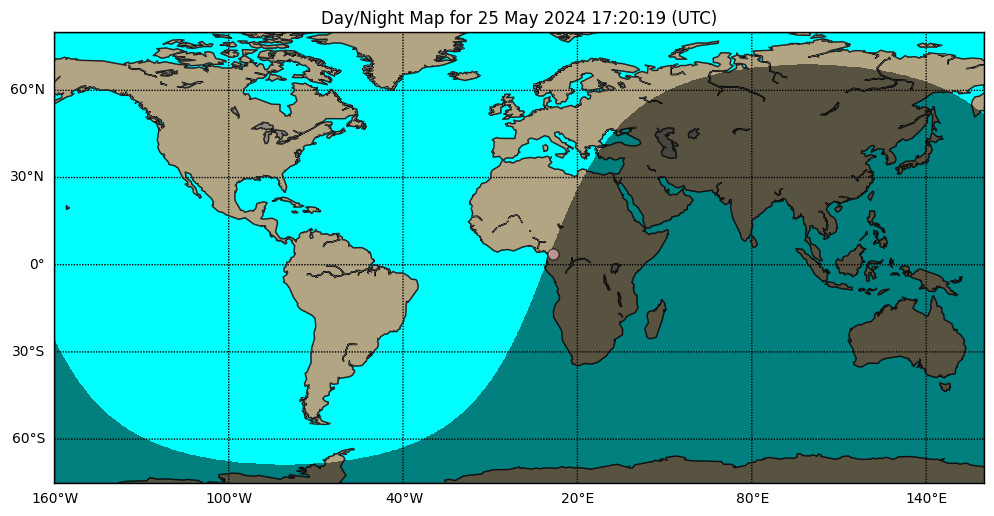

Sunseting at Yaoundé. It´s 18:20 LocalTime
Añadida nueva hora anochecer:18:20


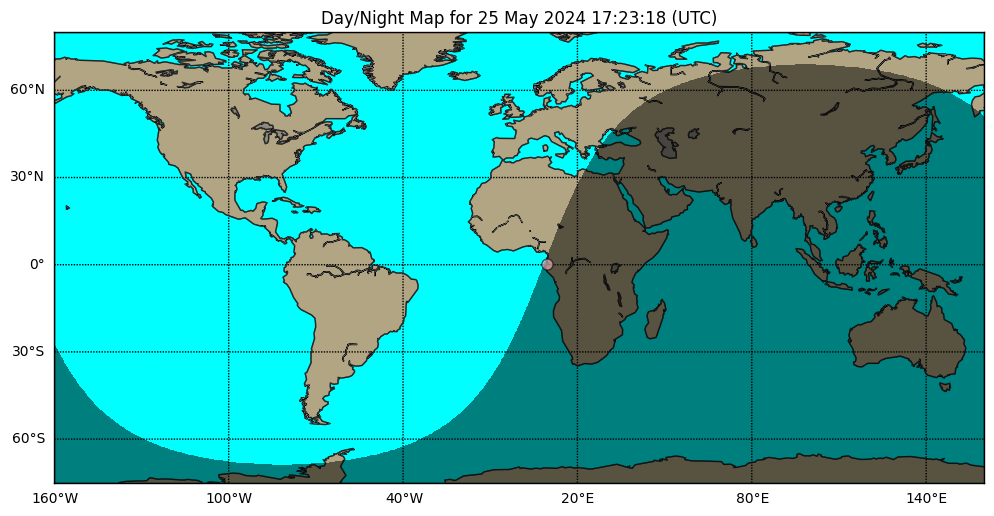

Sunseting at Libreville. It´s 18:23 LocalTime
Añadida nueva hora anochecer:18:23


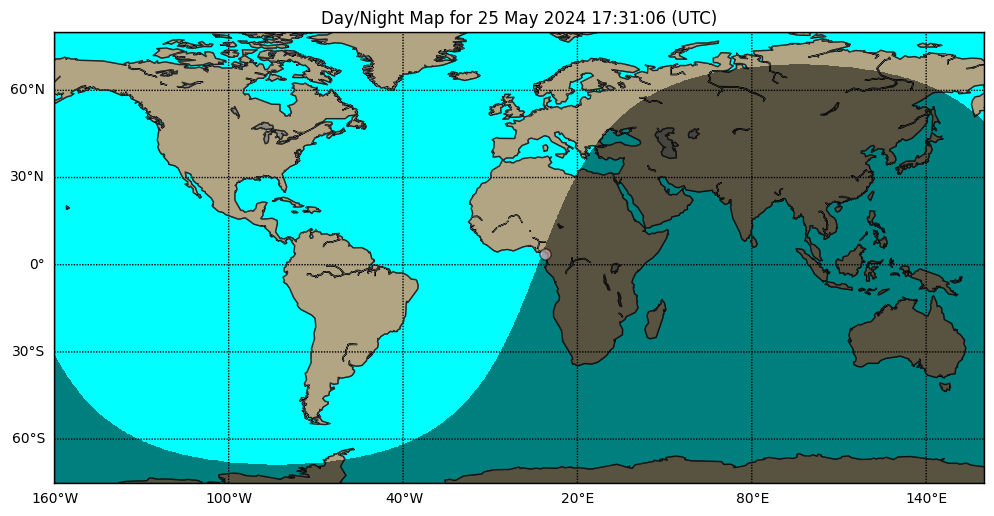

Sunseting at Malabo. It´s 18:31 LocalTime
Añadida nueva hora anochecer:18:31


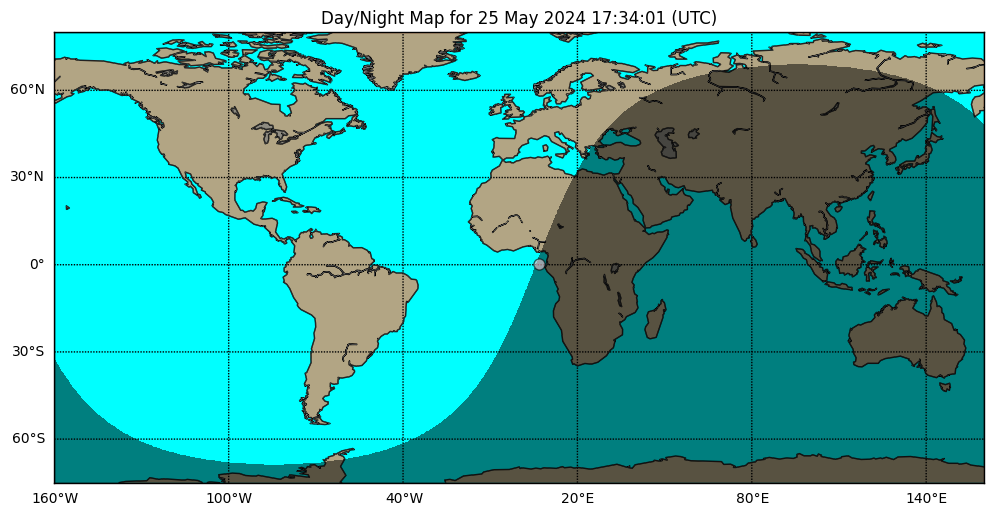

Sunseting at Sao Tomé. It´s 17:34 LocalTime
Añadida nueva hora anochecer:17:34


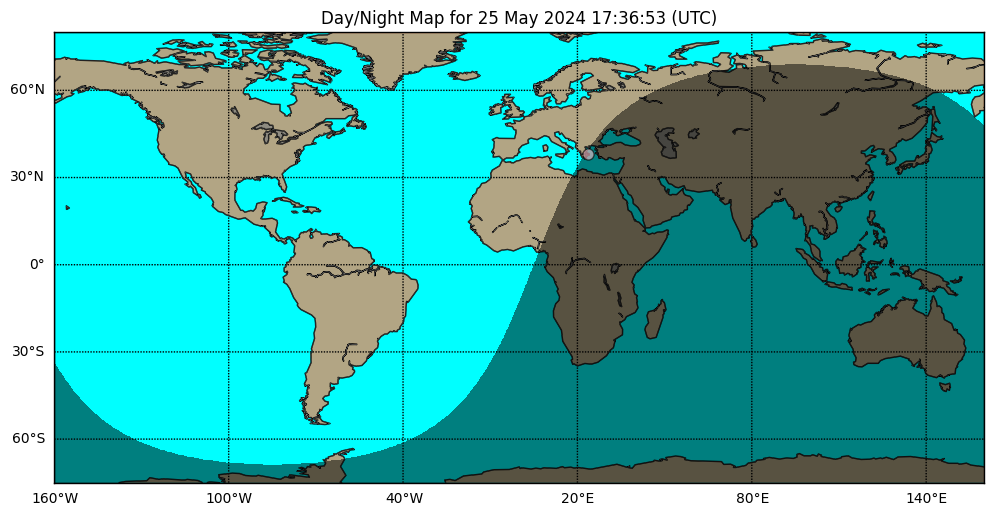

Sunseting at Athens. It´s 20:36 LocalTime
Añadida nueva hora anochecer:20:37


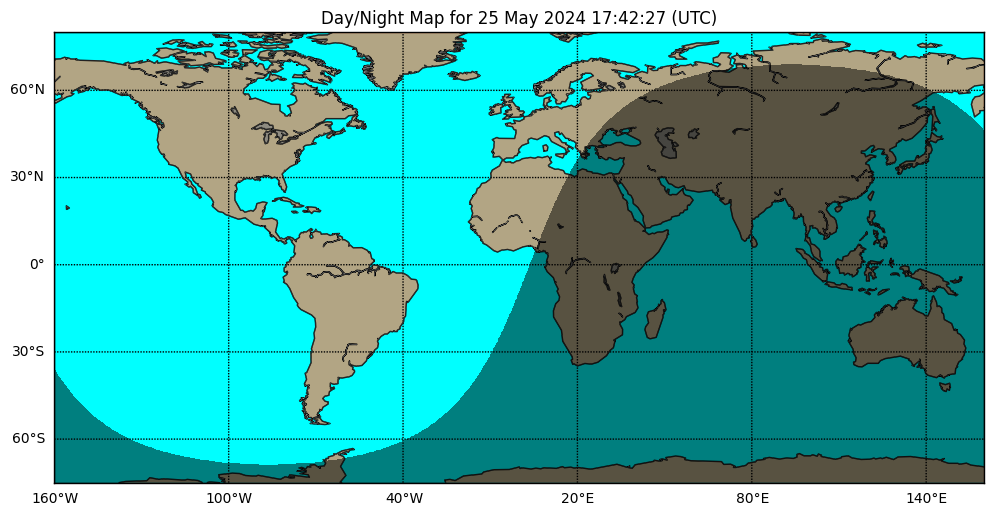

Sunrising at Apia. It´s 06:42 LocalTime
Añadida nueva hora amanecer: 06:42


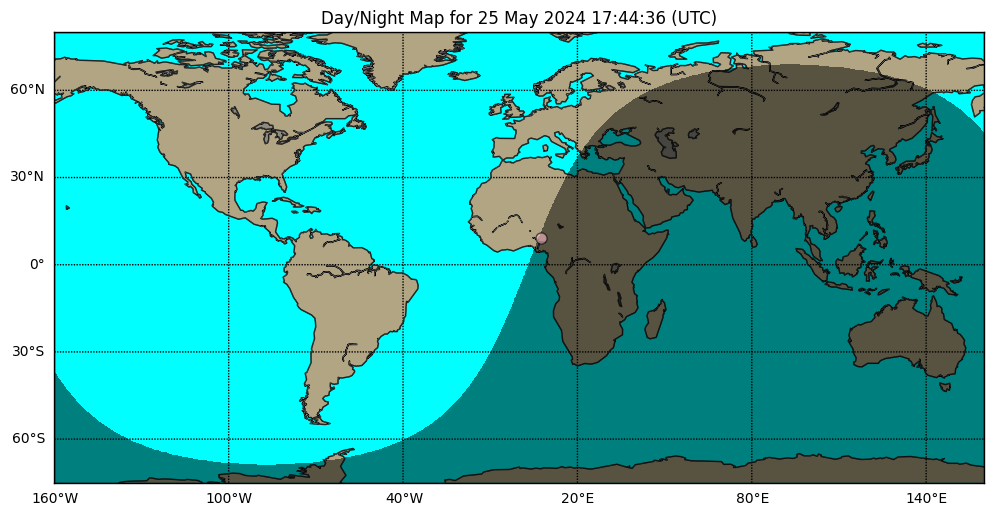

Sunseting at Abuja. It´s 18:44 LocalTime
Añadida nueva hora anochecer:18:44


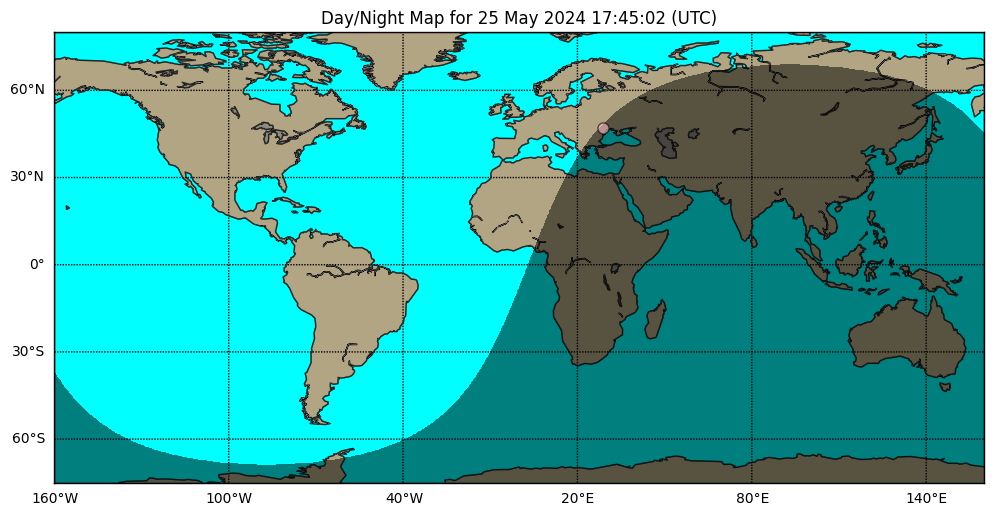

Sunseting at Chisinau. It´s 20:45 LocalTime
Añadida nueva hora anochecer:20:46


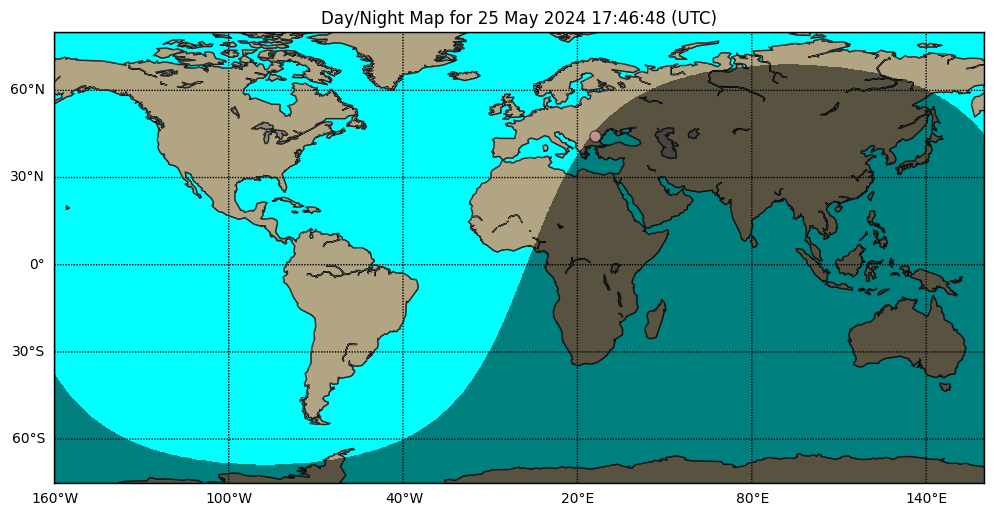

Sunseting at Bucharest. It´s 20:46 LocalTime
Añadida nueva hora anochecer:20:47


KeyboardInterrupt: 

In [45]:
s.run()

In [48]:
s.queue[1]

Event(time=1716659539, priority=1, sequence=105, action=<function accion at 0x11e68b600>, argument=(), kwargs={'ciudad': 'Moscow', 'que': 'anochece', 'hora': datetime.datetime(2024, 5, 25, 17, 52, 19, 954066, tzinfo=datetime.timezone.utc)})

In [17]:
time.gmtime(1716698998)

time.struct_time(tm_year=2024, tm_mon=5, tm_mday=26, tm_hour=4, tm_min=49, tm_sec=58, tm_wday=6, tm_yday=147, tm_isdst=0)

In [64]:
class Gallo:

    
    def __init__(self,google_key_,path_proyecto,token_elgalloaurora,apikey,apisecretkey,AccessToken,AccessTokenSecret):
       self.google_key=google_key_
       self.path_proyecto = path_proyecto
       self.token = token_elgalloaurora
       self.apikey = apikey
       self.apisecretkey = apisecretkey
       self.AccessToken = AccessToken
       self.AccessTokenSecret = AccessTokenSecret
       return
        
    def load_cities_formatted(self,fichero_ciudades_formateados):
        cities=pd.read_csv(fichero_ciudades_formateados).set_index('Ciudad')
        self.ciudades=cities
        return cities
    
    def load_cities_raw(self,fichero_ciudades_raw):
        def loc(x):
            print (f"Geocode {x}")
            return gmaps.geocode(x)[0]['geometry']['location']

        def tz(x):
            print (f"Tzone {x}")
            return gmaps.timezone(x)
        gmaps = googlemaps.Client(key=google_key)
        ciudades = (pd.read_csv(fichero_ciudades_raw,names=['Pais','Ciudad','Continente']).loc[:,:]
        .assign(localizacion = lambda x : x['Ciudad']+','+x['Pais'])
        .assign(localizacion = lambda df_ : df_.localizacion.map(loc))
        .assign(longitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lng']))
        .assign(latitud= lambda df_ : df_.localizacion.map(lambda x : dict(x)['lat']))
        .assign(timezone = lambda df_ : df_.localizacion.map(tz))
        .assign(dstOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['dstOffset']))
        .assign(rawOffset = lambda df_ : df_.timezone.map(lambda x: dict(x)['rawOffset']))
        .assign(timeZoneId = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneId']))
        .assign(timeZoneName = lambda df_ : df_.timezone.map(lambda x: dict(x)['timeZoneName']))
        .loc[:,['Ciudad','Pais','Continente','longitud','latitud','dstOffset','rawOffset','timeZoneId','timeZoneName']]
        .set_index()
                        )
        self.ciudades=ciudades
        return ciudades
        
    def save_cities(self,path_fichero):
        self.ciudades.to_csv(path_fichero,header=False,index=False)

        
    
    
    def mapa(self,ciudad,path):
        plt.figure(figsize=(12,6))
        map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,lon_0=100)
        #map = Basemap(llcrnrlon=-16, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80)
        # plot coastlines, draw label meridians and parallels.
        map.drawcoastlines()
        map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
        # fill continents 'coral' (with zorder=0), color wet areas 'aqua'
        map.drawmapboundary(fill_color='aqua')
        #map.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
        #map.fillcontinents(color='coral',lake_color='aqua')
        map.fillcontinents(color='coral', alpha=0.7, lake_color='grey')
        map.drawcoastlines(linewidth=0.1, color="white")

        date = datetime.now(timezone('utc'))
        CS=map.nightshade(date)
        
        # Add a marker per city of the data frame!
        map.plot(self.ciudades.loc[ciudad,'longitud'], self.ciudades.loc[ciudad,'latitud'], linestyle='none', marker='o', markersize=16, 
                 alpha=0.6, c="blue", markeredgecolor="black", markeredgewidth=1)
        plt.title('Day/Night Map for {} (UTC)'.format(date.strftime("%d %b %Y %H:%M:%S")))
        path_fichero = f"{self.path_proyecto}img/mapa.png"
        plt.savefig(path_fichero)
        plt.show()
        plt.close() #añadido para evitar muchas abiertas
        return path_fichero
    
   
    def enviar_tweet(self,accion,ciudad,hora_utc,nueva_hora,path_fichero):
        CR='\n'
        hora='%H:%M:%S'
        textos={'amanece':('Good morning','sun rising'),'anochece':('Good evening','sunset')}
        auth = tweepy.OAuth1UserHandler(self.apikey,self.apisecretkey)
        auth.set_access_token(self.AccessToken,self.AccessTokenSecret)
        api = tweepy.API(auth)
        media = api.media_upload(filename=path_fichero)
        media_id = media.media_id
        cliente = tweepy.Client(bearer_token=self.token,
                          consumer_key=self.apikey,
                          consumer_secret=self.apisecretkey,
                          access_token=self.AccessToken,
                          access_token_secret=self.AccessTokenSecret)
        Text1=('{}, {} at {}, {} ({})'.format(textos[accion][0],textos[accion][1],'#'+ciudad.replace(' ',''),
                                                                  '#'+self.ciudades.loc[ciudad,'Pais'],
                                                                  '#'+self.ciudades.loc[ciudad,'Continente']))
        Text2=('{0:<10} {1:<15}'.format('UTC time',hora_utc.strftime(hora)))
        Text3=('{0:<10} {1:<15}'.format('Local time',hora_utc.astimezone(timezone(self.ciudades.loc[ciudad,'timeZoneId'])).strftime(hora)))
        Text4=('{0:<10} {1} at {2:<15}'.format('Tomorrow',textos[accion][1],nueva_hora.strftime(hora)))
        #Text5='#roostercrow'
        Text5='#elgallodelaaurora'
        texto=Text1+CR+Text2+CR+Text3+CR+Text4+CR+Text5
        print (texto)
        #return cliente.create_tweet(text=texto)
        return cliente.create_tweet(text=texto,media_ids=[media_id])

    
    def run(self):
        self.s.run()
        return
    
    
    def inicia_schedule(self):
        for i in self.ciudades.index:
            city = LocationInfo(i, self.ciudades.loc[i,'Pais'], self.ciudades.loc[i,'timeZoneId'], self.ciudades.loc[i,'latitud'], self.ciudades.loc[i,'longitud'])
            hoy = datetime.today() #.astimezone(timezone(ciudades.loc[i,'timeZoneId']))
            
            sol = sun(city.observer, date=hoy)
            print (f"{city.name}: amanece a las {sol['sunrise'].strftime('%H:%M')}/{sol['sunrise'].astimezone(timezone(self.ciudades.loc[i,'timeZoneId'])).strftime('%H:%M')}@{calendar.timegm(sol['sunrise'].timetuple())}, anochece a las {sol['sunset'].strftime('%H:%M')}@{calendar.timegm(sol['sunset'].timetuple())}")
            if sol['sunrise']>datetime.now(timezone('UTC')):
                self.s.enterabs(calendar.timegm(sol['sunrise'].timetuple()),1,self.accion,kwargs={'ciudad':city.name,'que':'amanece','hora':sol['sunrise']})
                print(f"Añadida nueva hora amanecer: {sol['sunrise'].astimezone(timezone(self.ciudades.loc[city.name,'timeZoneId'])).strftime('%H:%M')}")
            else:
                sol = sun(city.observer, date=hoy+timedelta(days=1))
                self.s.enterabs(calendar.timegm(sol['sunrise'].timetuple()),1,self.accion,kwargs={'ciudad':city.name,'que':'amanece','hora':sol['sunrise']})
                print(f"Añadida nueva hora amanecer:{sol['sunrise'].astimezone(timezone(self.ciudades.loc[city.name,'timeZoneId'])).strftime('%H:%M')}")
            if sol['sunset']>datetime.now(timezone('UTC')):
                self.s.enterabs(calendar.timegm(sol['sunset'].timetuple()),1,self.accion,kwargs={'ciudad':city.name,'que':'anochece','hora':sol['sunset']})
                print(f"Añadida nueva hora anochecer: {sol['sunset'].astimezone(timezone(self.ciudades.loc[city.name,'timeZoneId'])).strftime('%H:%M')}")
            else:
                sol = sun(city.observer, date=hoy+timedelta(days=1))
                self.s.enterabs(calendar.timegm(sol['sunset'].timetuple()),1,self.accion,kwargs={'ciudad':city.name,'que':'anochece','hora':sol['sunset']})
                print(f"Añadida nueva hora anochecer: {sol['sunset'].astimezone(timezone(self.ciudades.loc[city.name,'timeZoneId'])).strftime('%H:%M')}")
        
            
               
        return

    def accion(self,ciudad='Madrid',que='amanece',hora=''):
        city = LocationInfo(ciudad, self.ciudades.loc[ciudad,'Pais'], self.ciudades.loc[ciudad,'timeZoneId'], self.ciudades.loc[ciudad,'latitud'], self.ciudades.loc[ciudad,'longitud'])
        mañana = datetime.now(timezone('UTC'))+timedelta(days=1)
        sol = sun(city.observer, date=mañana)
        #map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,projection='mill',lon_0=0)
        path = self.mapa(ciudad,self.path_proyecto)
        print (path)
        if que=='amanece':
            print (f"Sunrising at {ciudad}. It´s {hora.astimezone(timezone(self.ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')} LocalTime")
            nueva_hora = sol['sunrise']
            self.s.enterabs(calendar.timegm(sol['sunrise'].timetuple()),1,self.accion,kwargs={'ciudad':ciudad,'que':que,'hora':sol['sunrise']})
            print(f"Añadida nueva hora amanecer: {sol['sunrise'].astimezone(timezone(self.ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')}")
            self.enviar_tweet('amanece',ciudad,hora,nueva_hora,path)
        if que=='anochece':
            print (f"Sunseting at {ciudad}. It´s {hora.astimezone(timezone(self.ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')} LocalTime")
            nueva_hora = sol['sunset']
            self.s.enterabs(calendar.timegm(sol['sunset'].timetuple()),1,self.accion,kwargs={'ciudad':ciudad,'que':que,'hora':sol['sunset']})
            print(f"Añadida nueva hora anochecer:{sol['sunset'].astimezone(timezone(self.ciudades.loc[ciudad,'timeZoneId'])).strftime('%H:%M')}")
            self.enviar_tweet('anochece',ciudad,hora,nueva_hora,path)
            
        return

In [65]:
fichero='cities.csv'
fichero_formateado_corto='cities_formatted.csv'
fichero_formateado_largo = 'cities_long_formatted.csv'
path_proyecto = '/Users/mharias/documents/proyectos/gallo_aurora/'

In [55]:
from pass_esios import token_walyt,apikey_walyt,apisecretkey_walyt,AccessToken_walyt,AccessTokenSecret_walyt

In [66]:
gallo=Gallo(google_key,path_proyecto,token_elgalloaurora, apikey, apisecretkey, AccessToken,AccessTokenSecret)
#gallo=Gallo(google_key,path_proyecto,token_walyt,apikey_walyt,apisecretkey_walyt,AccessToken_walyt,AccessTokenSecret_walyt)
gallo.ciudades = gallo.load_cities_formatted(fichero_formateado_corto)

In [21]:
print (token_elgalloaurora, apikey, apisecretkey, AccessToken,AccessTokenSecret)

AAAAAAAAAAAAAAAAAAAAAMPltwEAAAAALDqaxBUPPRM9aZoWL8Qh9M8nqWM%3Dj8vrzWvrFNGagFclOpPyzCxddjDn0RhtnYWSjtpAshR87W0eDJ FIIcU64mTaULfOofn14PKD8dq NxHMUK32b0OKINKKXnpTuSiS8oOdGwFGJqGYdyApj8kHhjButn 849852672886919170-hORYBGX3EyOKbmxNsxZAYmfuoCdKVGC 9B5oK9Vya4vtvfREtOOOKSiBlf8J0fZBjud8MOfG3XNNM


In [67]:
gallo.s = sched.scheduler(time.time,time.sleep)

In [68]:
gallo.inicia_schedule()

Algiers: amanece a las 04:33/05:33@1716697982, anochece a las 18:57@1716749825
Añadida nueva hora amanecer:05:32
Añadida nueva hora anochecer: 19:57
Luanda: amanece a las 05:14/06:14@1716700472, anochece a las 16:53@1716742427
Añadida nueva hora amanecer:06:14
Añadida nueva hora anochecer: 17:53
Buenos Aires: amanece a las 10:48/07:48@1716720518, anochece a las 20:52@1716756747
Añadida nueva hora amanecer:07:49
Añadida nueva hora anochecer: 17:52
Canberra: amanece a las 21:00/07:00@1716757227, anochece a las 07:01@1716706864
Añadida nueva hora amanecer: 07:00
Añadida nueva hora anochecer: 17:00
Brussels: amanece a las 03:39/05:39@1716694781, anochece a las 19:40@1716752425
Añadida nueva hora amanecer:05:38
Añadida nueva hora anochecer: 21:41
Brasilia: amanece a las 09:30/06:30@1716715823, anochece a las 20:46@1716756414
Añadida nueva hora amanecer:06:30
Añadida nueva hora anochecer: 17:46
Beijing: amanece a las 20:50/04:50@1716756638, anochece a las 11:32@1716723126
Añadida nueva hora 

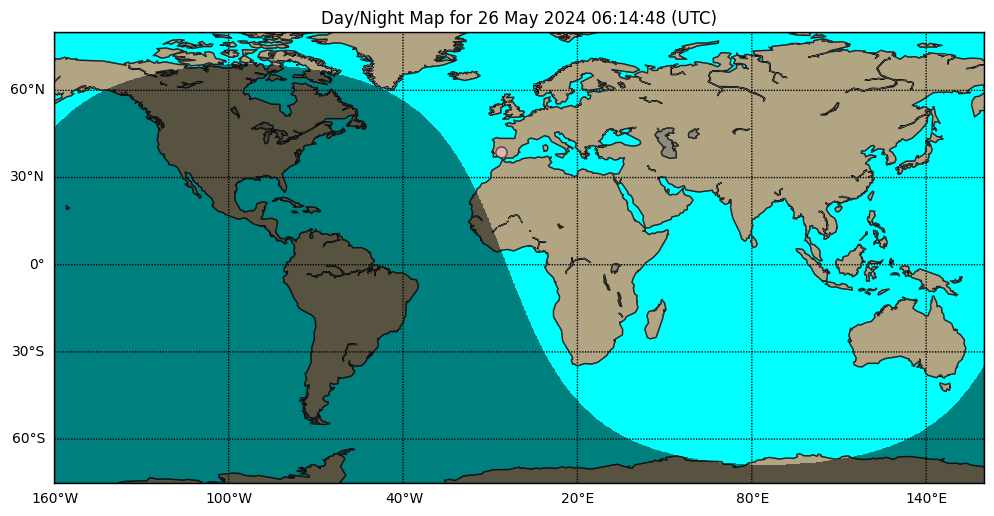

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunrising at Almendralejo. It´s 08:14 LocalTime
Añadida nueva hora amanecer: 07:05
Good morning, sun rising at #Almendralejo, #Spain (#Europe)
UTC time   06:14:47       
Local time 08:14:47       
Tomorrow   sun rising at 05:05:08       
#elgallodelaaurora


In [12]:
gallo.accion(ciudad='Almendralejo',que='amanece',hora=datetime.now(timezone('UTC')))

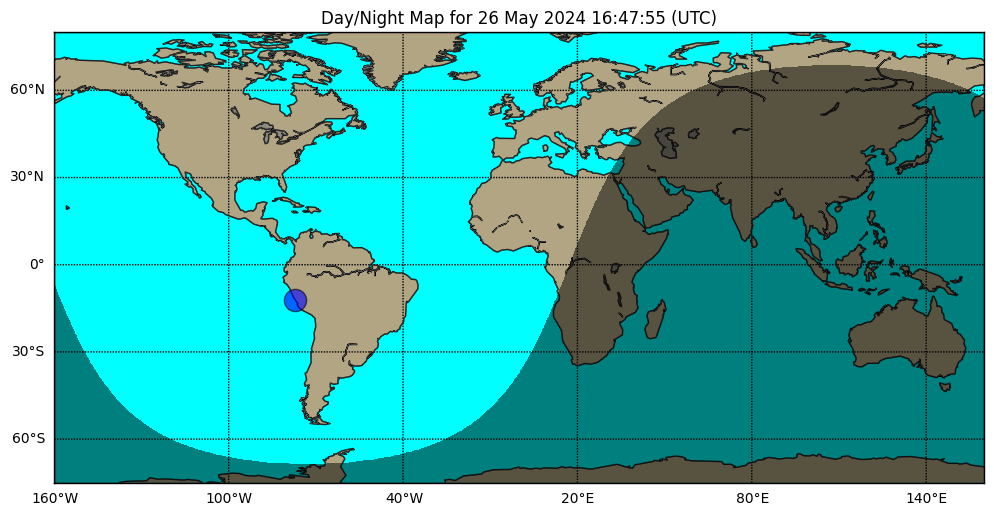

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunrising at Lima. It´s 06:20 LocalTime
Añadida nueva hora amanecer: 06:21
Good morning, sun rising at #Lima, #Peru (#America)
UTC time   11:20:51       
Local time 06:20:51       
Tomorrow   sun rising at 11:21:08       
#elgallodelaaurora


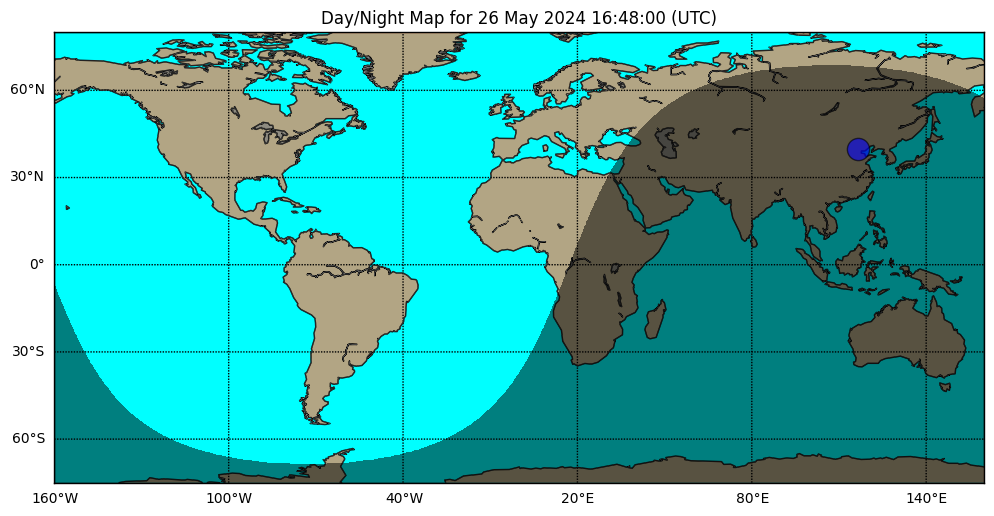

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunseting at Beijing. It´s 19:32 LocalTime
Añadida nueva hora anochecer:19:32
Good evening, sunset at #Beijing, #China (#Asia)
UTC time   11:32:06       
Local time 19:32:06       
Tomorrow   sunset at 11:32:54       
#elgallodelaaurora


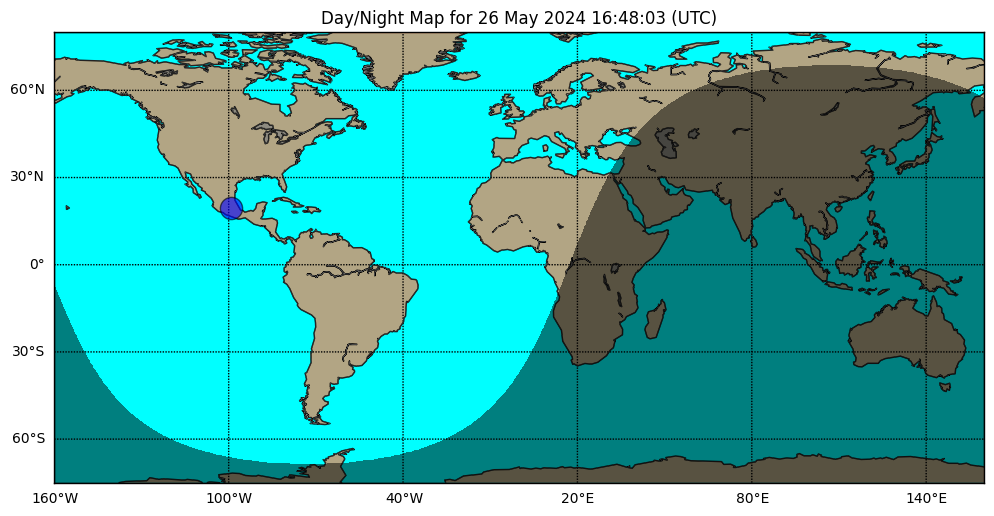

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunrising at Mexico City. It´s 05:58 LocalTime
Añadida nueva hora amanecer: 05:58
Good morning, sun rising at #MexicoCity, #Mexico (#America)
UTC time   11:58:27       
Local time 05:58:27       
Tomorrow   sun rising at 11:58:18       
#elgallodelaaurora


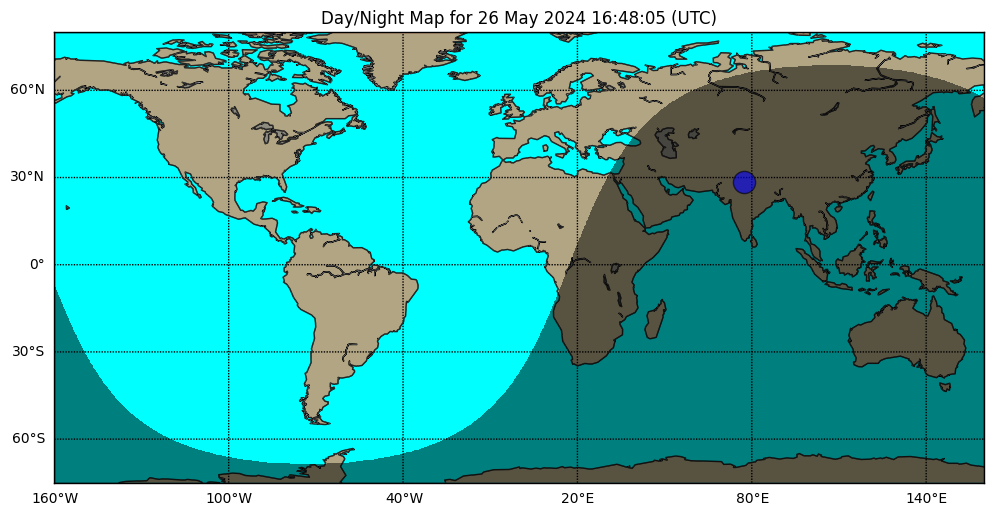

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunseting at New Delhi. It´s 19:11 LocalTime
Añadida nueva hora anochecer:19:11
Good evening, sunset at #NewDelhi, #India (#Asia)
UTC time   13:41:17       
Local time 19:11:17       
Tomorrow   sunset at 13:41:50       
#elgallodelaaurora


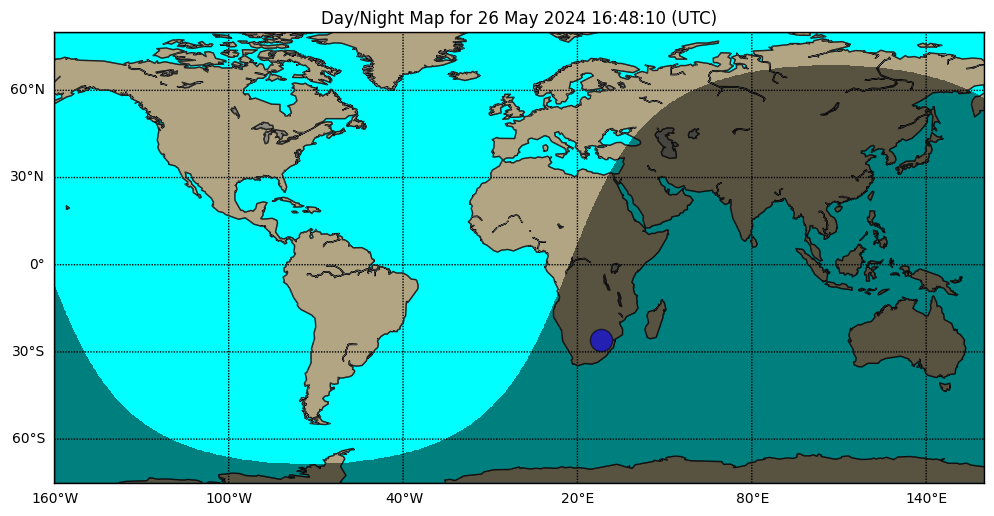

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunseting at Pretoria. It´s 17:24 LocalTime
Añadida nueva hora anochecer:17:24
Good evening, sunset at #Pretoria, #South Africa (#Africa)
UTC time   15:24:51       
Local time 17:24:51       
Tomorrow   sunset at 15:24:36       
#elgallodelaaurora


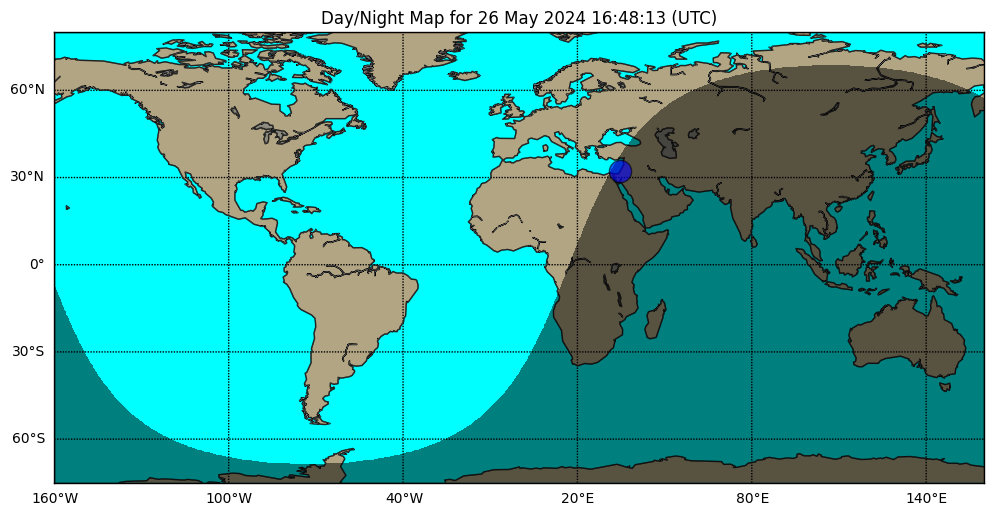

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunseting at Tel Aviv. It´s 19:38 LocalTime
Añadida nueva hora anochecer:19:39
Good evening, sunset at #TelAviv, #Israel (#Asia)
UTC time   16:38:43       
Local time 19:38:43       
Tomorrow   sunset at 16:39:20       
#elgallodelaaurora


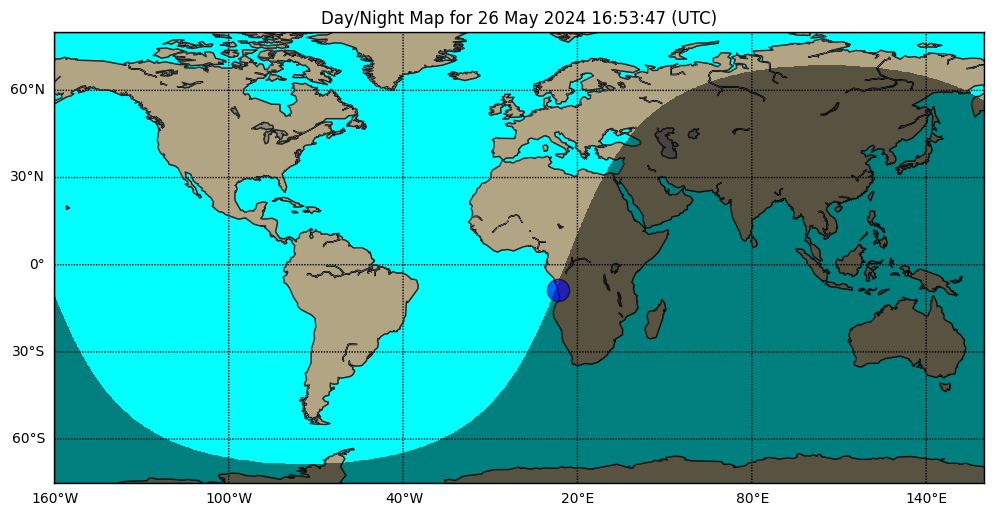

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunseting at Luanda. It´s 17:53 LocalTime
Añadida nueva hora anochecer:17:53
Good evening, sunset at #Luanda, #Angola (#Africa)
UTC time   16:53:47       
Local time 17:53:47       
Tomorrow   sunset at 16:53:47       
#elgallodelaaurora


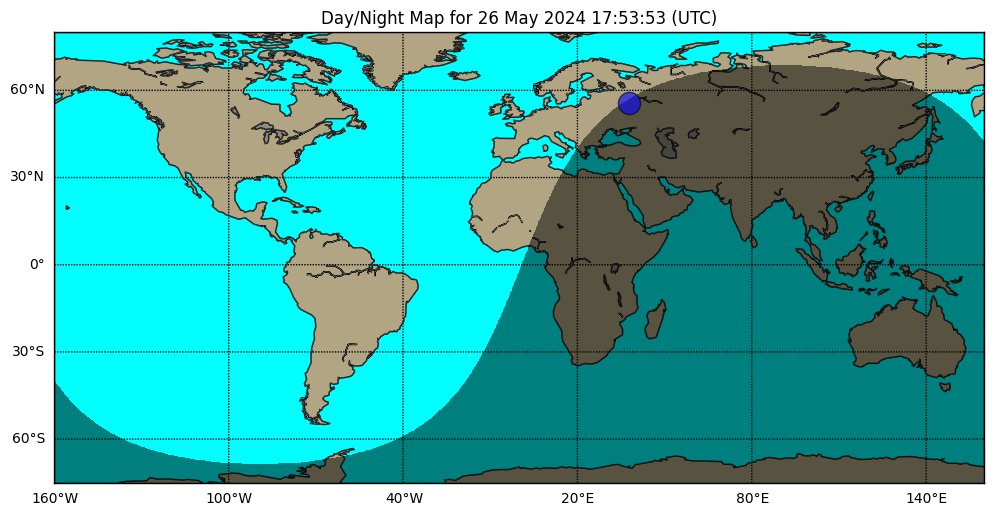

/Users/mharias/documents/proyectos/gallo_aurora/img/mapa.png
Sunseting at Moscow. It´s 20:53 LocalTime
Añadida nueva hora anochecer:20:55
Good evening, sunset at #Moscow, #Russia (#Europe)
UTC time   17:53:53       
Local time 20:53:53       
Tomorrow   sunset at 17:55:24       
#elgallodelaaurora


KeyboardInterrupt: 

In [11]:
gallo.run()

In [35]:
gallo.s.queue

[Event(time=1716751747, priority=1, sequence=3, action=<bound method Gallo.accion of <__main__.Gallo object at 0x118853560>>, argument=(), kwargs={'ciudad': 'Tokyo', 'que': 'amanece', 'hora': datetime.datetime(2024, 5, 26, 19, 29, 7, 965020, tzinfo=datetime.timezone.utc)}),
 Event(time=1716756638, priority=1, sequence=1, action=<bound method Gallo.accion of <__main__.Gallo object at 0x118853560>>, argument=(), kwargs={'ciudad': 'Beijing', 'que': 'amanece', 'hora': datetime.datetime(2024, 5, 26, 20, 50, 38, 211333, tzinfo=datetime.timezone.utc)}),
 Event(time=1716757227, priority=1, sequence=0, action=<bound method Gallo.accion of <__main__.Gallo object at 0x118853560>>, argument=(), kwargs={'ciudad': 'Canberra', 'que': 'amanece', 'hora': datetime.datetime(2024, 5, 26, 21, 0, 27, 602726, tzinfo=datetime.timezone.utc)}),
 Event(time=1716767708, priority=1, sequence=2, action=<bound method Gallo.accion of <__main__.Gallo object at 0x118853560>>, argument=(), kwargs={'ciudad': 'New Delhi',